In [60]:
# Data manipulation and math computation
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import preprocessing

# Data visualisation 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import networkx as nx 
%matplotlib inline

# For statistical analysis
from scipy import stats

# Searchign for Outliers
from sklearn.ensemble import IsolationForest

# Metrics used for measuring the accuracy and performance of the models
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import RandomizedSearchCV

# ML algorithms for clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering

# ML algorithms for the classification
from xgboost import XGBClassifier
from xgboost import plot_importance
from xgboost import to_graphviz
from xgboost import plot_tree

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.wrappers.scikit_learn import KerasClassifier

# PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA

# ignore warnings from pandas
import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

# Load the dataset

In [75]:
# dataset after the graph analysis
df = pd.read_csv('lib/data/PartitionedNetwork.csv',sep=",")
# Setup indexing
df.index = df['Unnamed: 0']
df.index.name = ''
# and drop the corresponding column
df.drop(columns=['Unnamed: 0'],inplace=True)
print(df.shape)
df.head()

(5319, 37)


B_interactions_count  B_unique_id  A_interactions_count  A_unique_id  \
                                                                          
0                    34            0                    40          190   
1                    33            1                    39          113   
2                     3            2                     1          788   
3                    39            3                    38           99   
4                    37            4                    42          307   

   A_follower_count  A_following_count  A_listed_count  A_mentions_received  \
                                                                              
0               228                302               3             0.583979   
1             21591               1179             228            90.456506   
2              7310               1215             101            25.503644   
3                20                  7               2             7.690824   
4             45589                862            2641           148.854279   

   A_retweets_received  A_mentions_sent       ...        A_community  \
                                              ...                      
0             0.100503         0.100503       ...                  0   
1            25.798292         5.709329       ...                  2   
2             9.556347         5.361519       ...                  3   
3             0.277306         1.331508       ...                  4   
4            36.998884        27.881768       ...                  4   

   B_community  A_L_community  A_M_community  A_S_community  A_XS_community  \
                                                                              
0            1              1              0              0               0   
1            2              1              0              0               0   
2            3              0              0              1               0   
3            4              1              0              0               0   
4            4              1              0              0               0   

   B_L_community  B_M_community  B_S_community  B_XS_community  
                                                                
0              0              1              0               0  
1              1              0              0               0  
2              0              0              1               0  
3              1              0              0               0  
4              1              0              0               0  

[5 rows x 37 columns]

# Engineer features

In [3]:
# Create a bunch of "A-B" and "A+B" features
# Ignore for the moment
#minus_features = ['follower_count','interactions_count','following_count','listed_count','retweets_received','retweets_sent']
minus_features = ['follower_count','interactions_count','following_count','listed_count']
plus_features = ['follower_count','listed_count','following_count']
for col in minus_features:
    df['AmB_' + col] = df['A_'+col] - df['B_'+col]

df['A_follower_p_listed_count'] = df['A_follower_count'] + df['A_listed_count']
    
for cand in ['A','B']:
    df[cand + '_follower_m_following_count'] = df[cand + '_follower_count'] - df[cand + '_following_count']
    df[cand + '_received_m_send_mentions'] = df[cand + '_mentions_received'] - df[cand + '_mentions_sent']
    

In [4]:
# features and labels
df_y = df['Choice']
df_x = df.drop(columns=['Choice'])

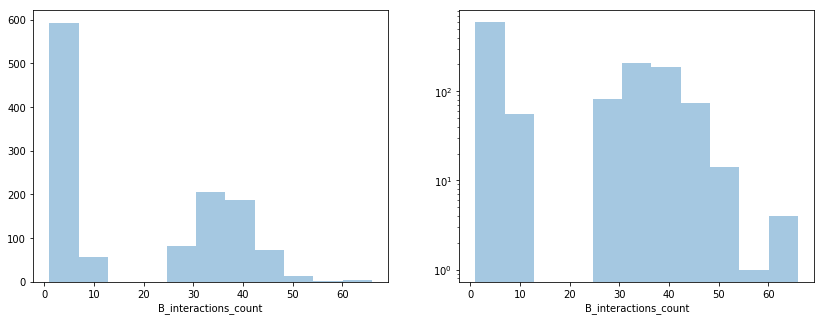

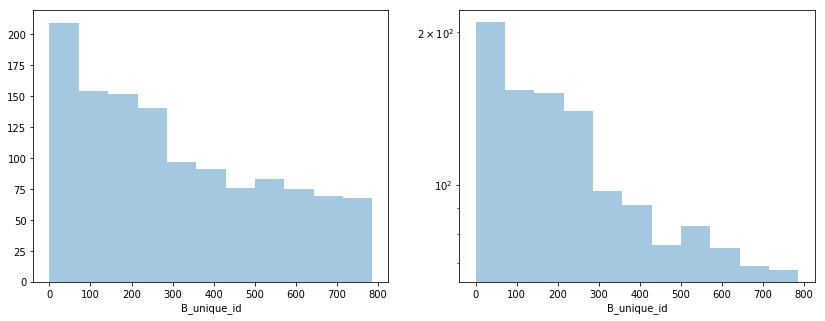

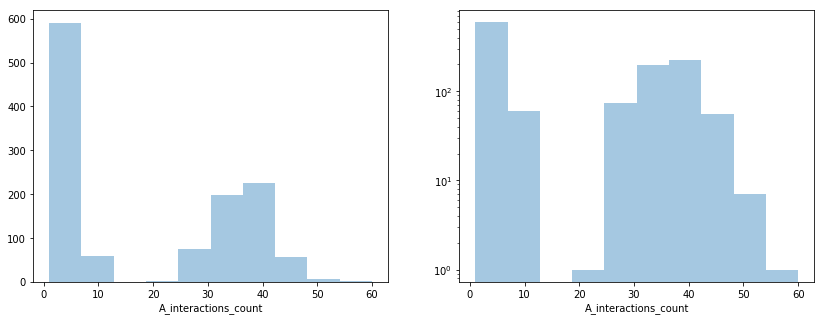

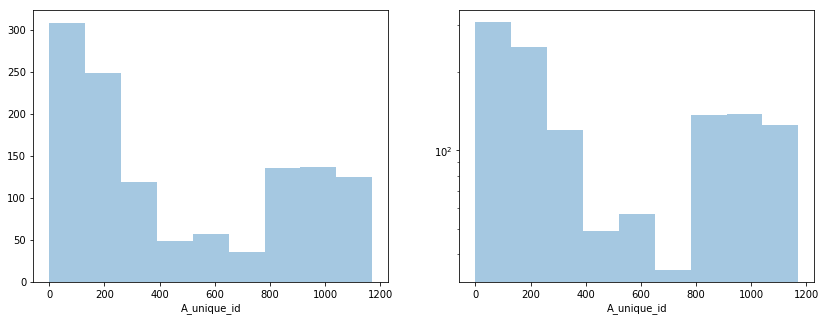

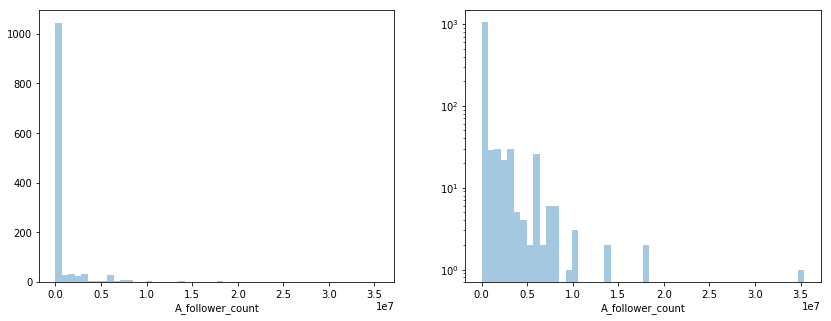

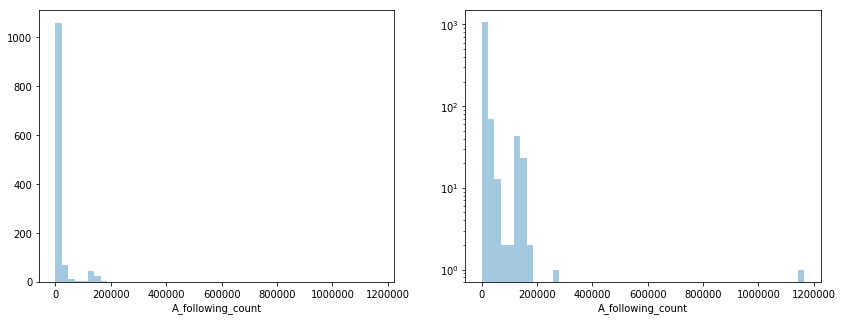

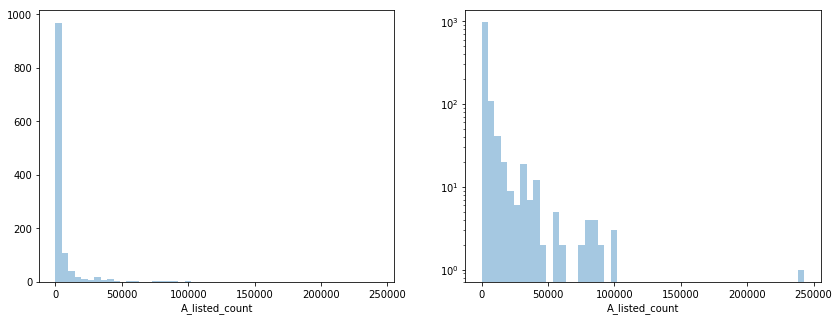

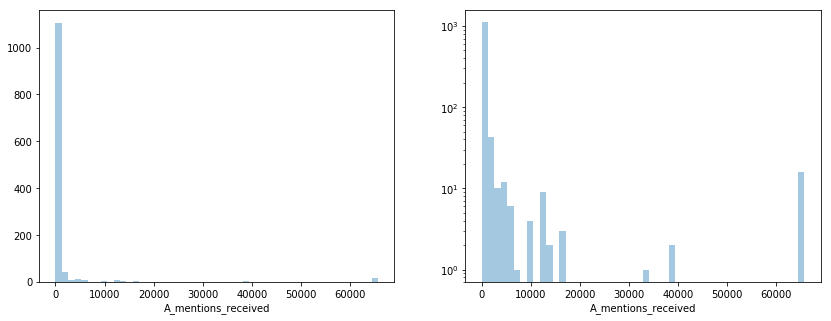

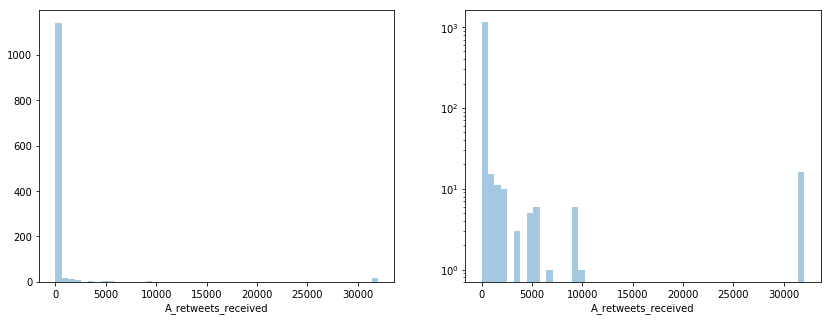

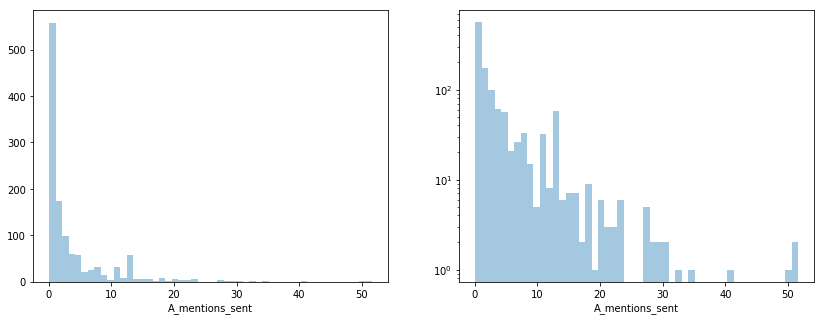

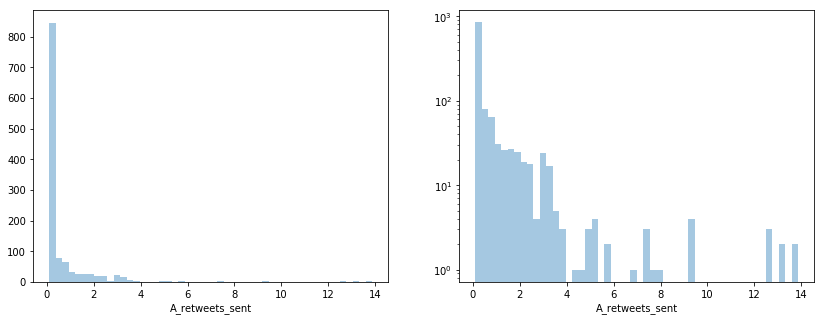

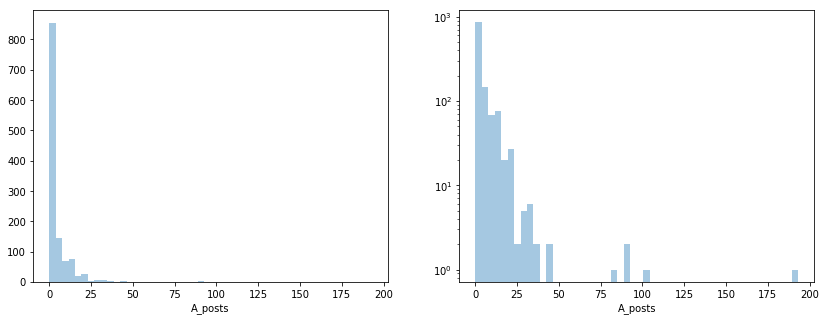

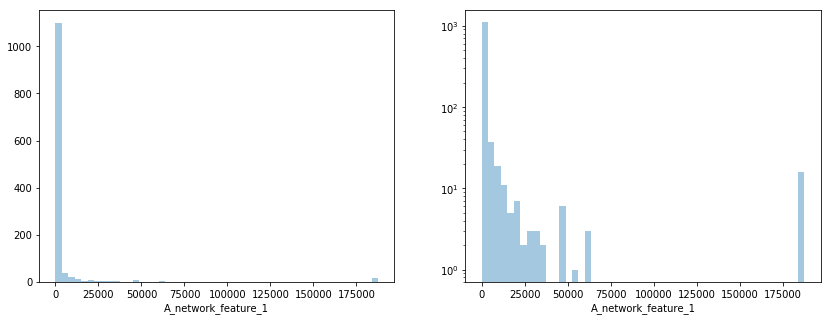

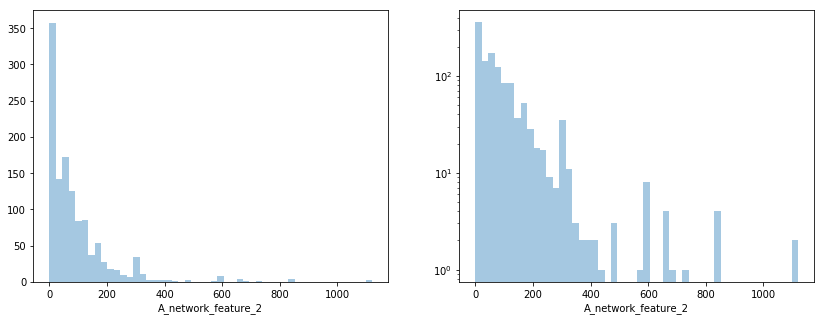

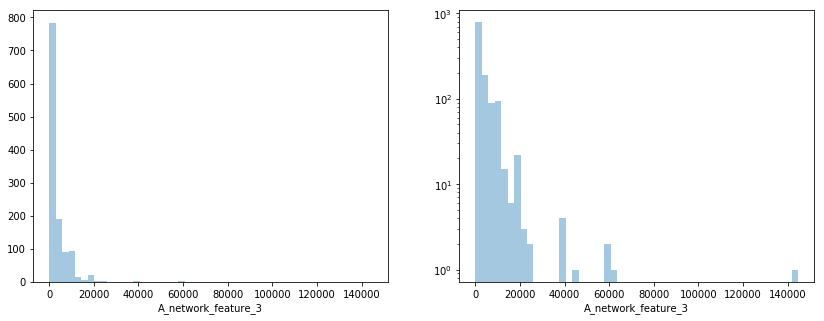

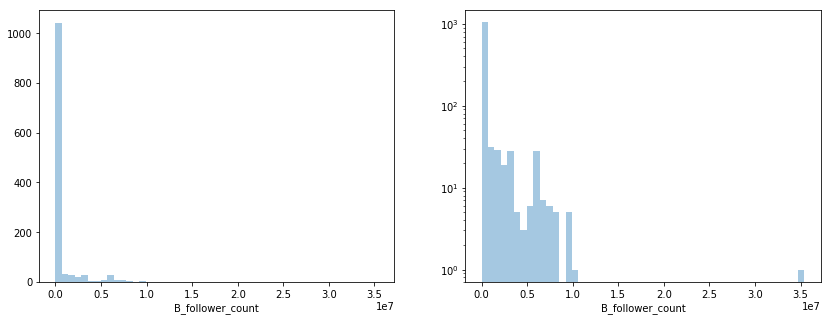

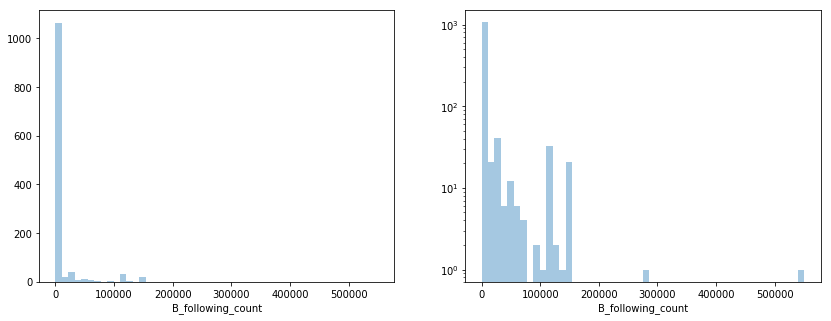

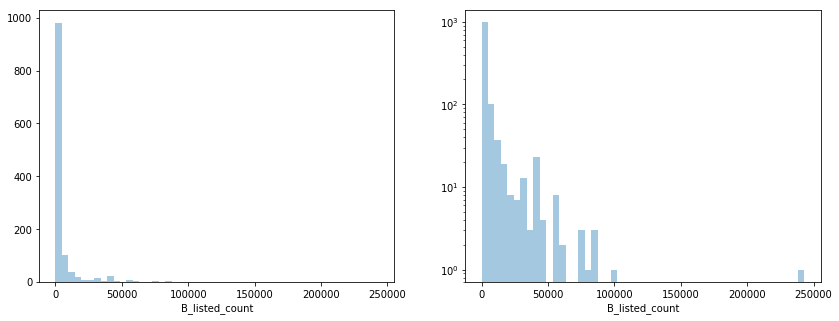

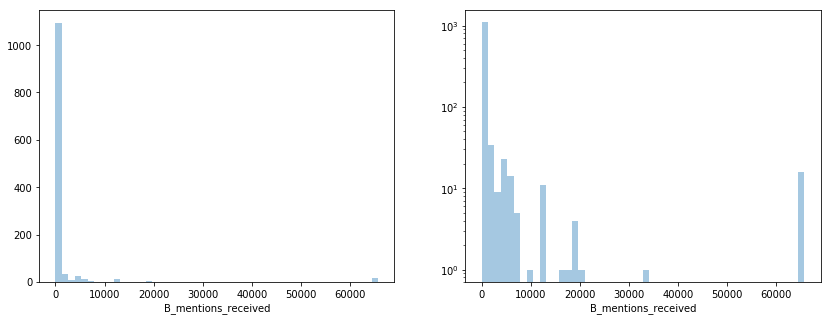

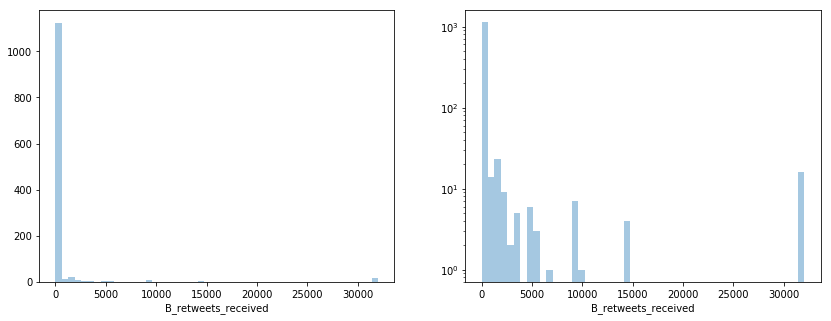

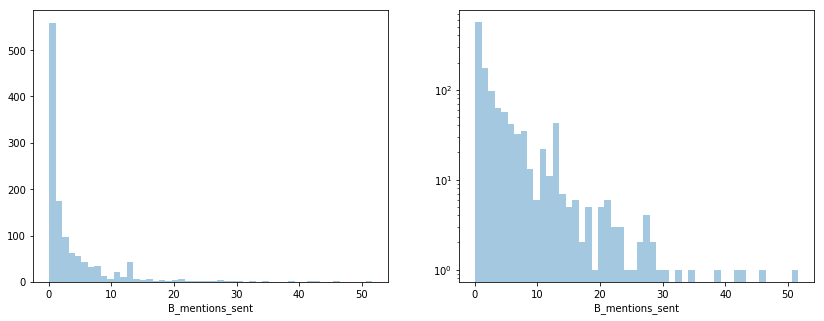

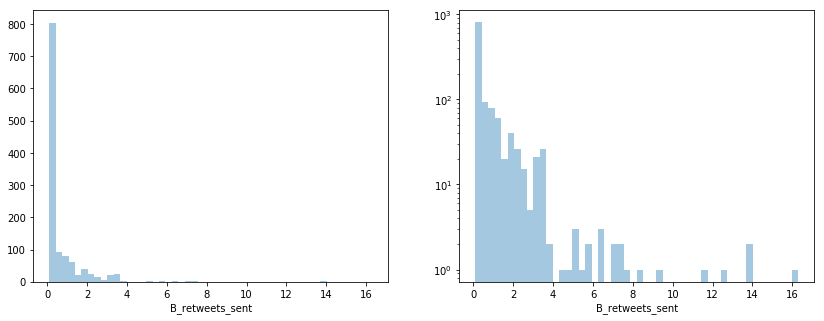

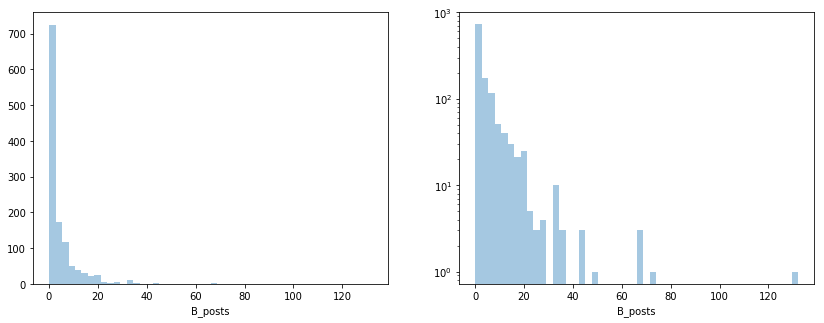

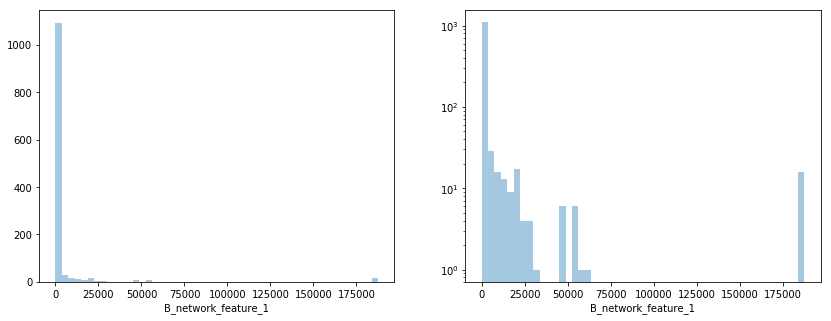

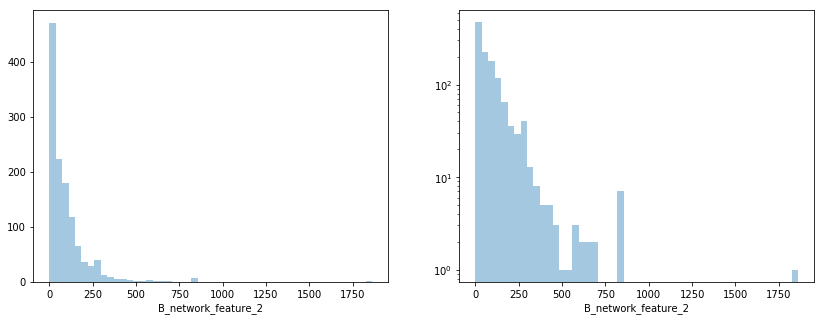

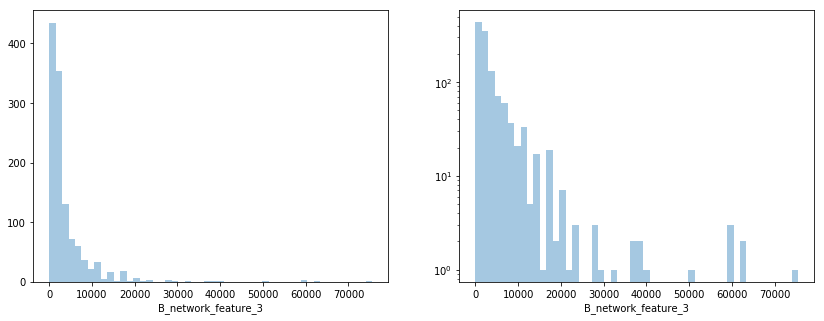

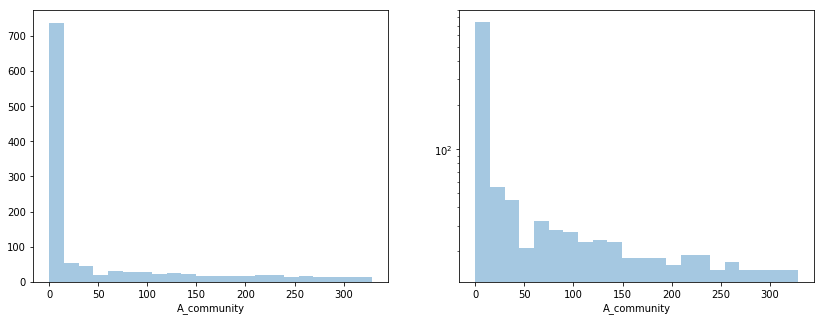

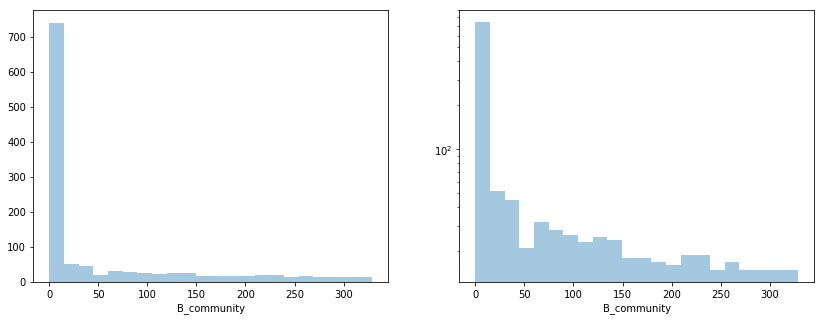

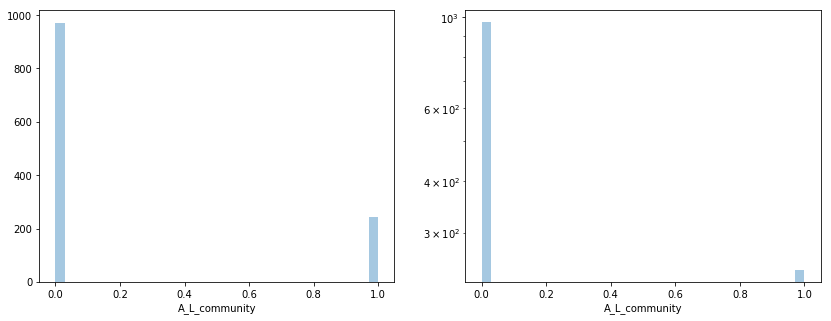

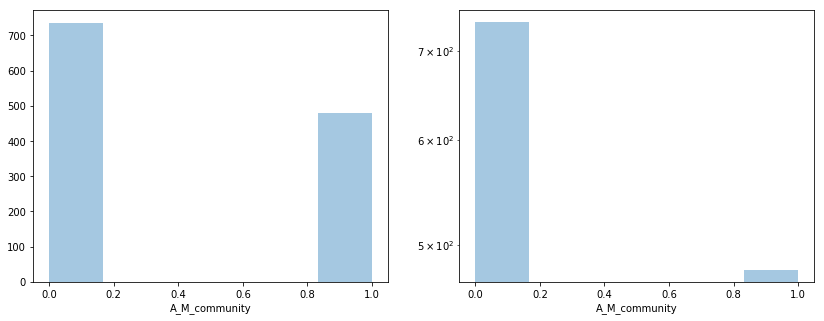

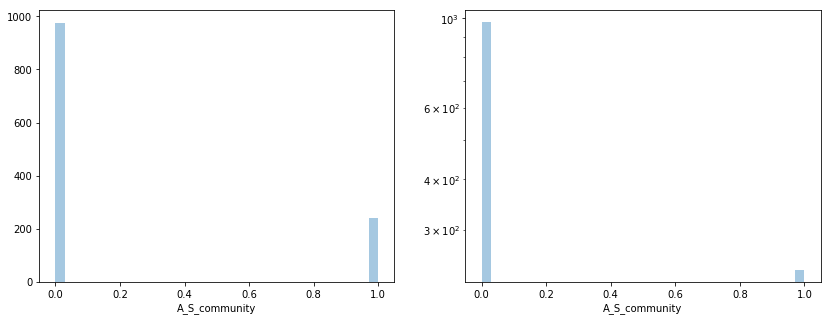

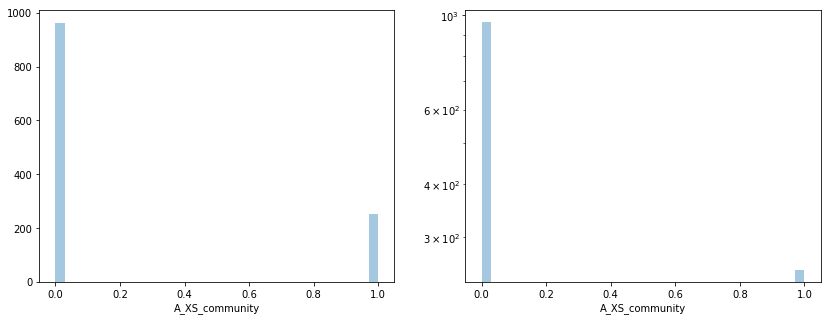

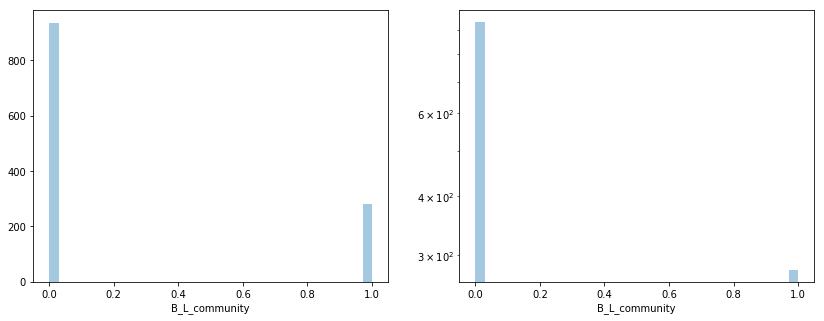

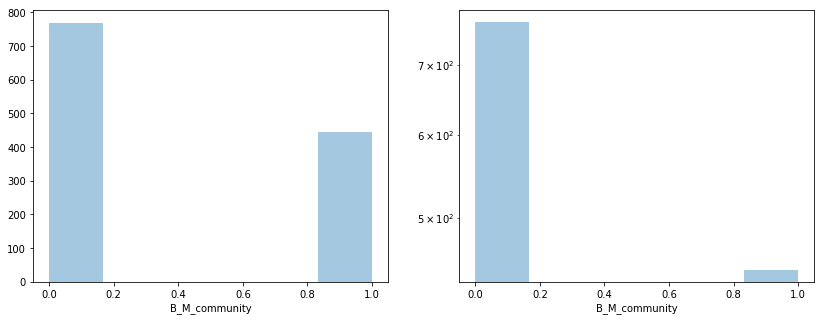

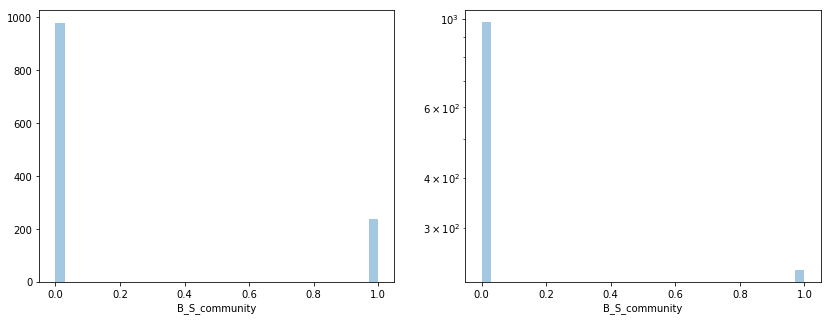

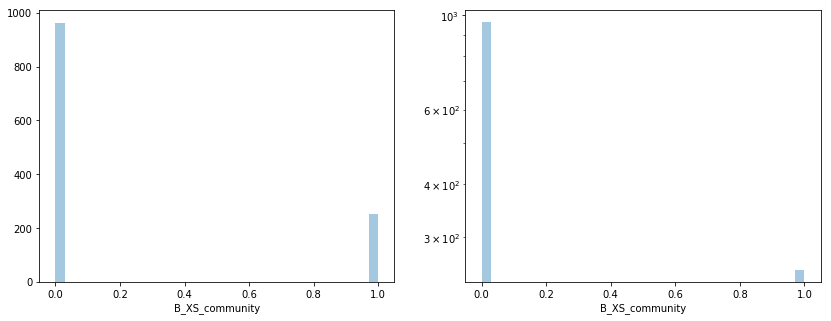

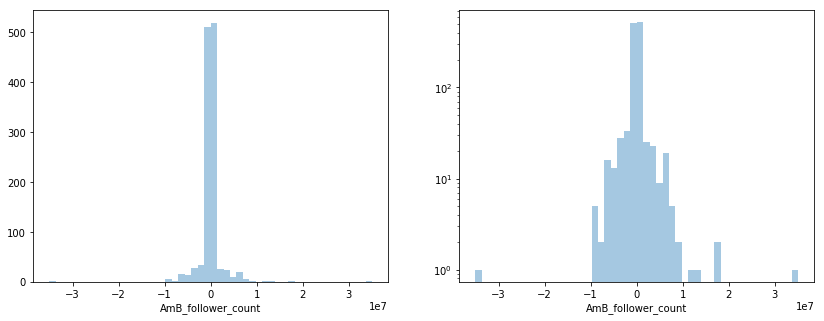

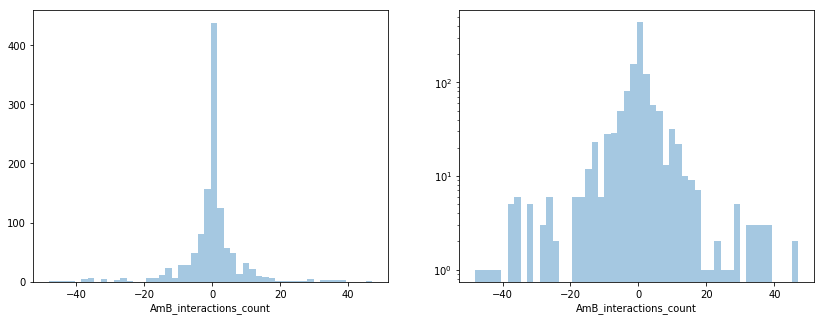

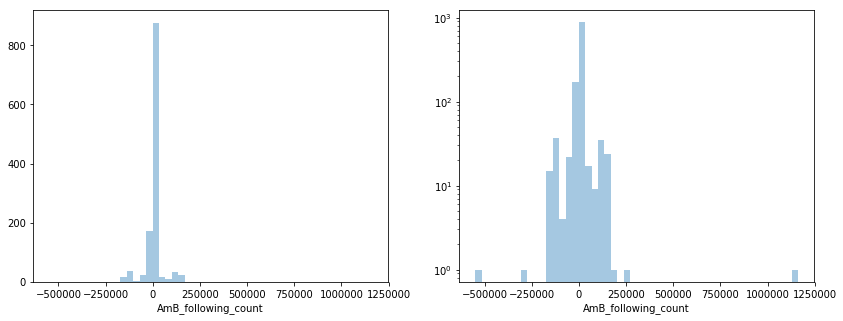

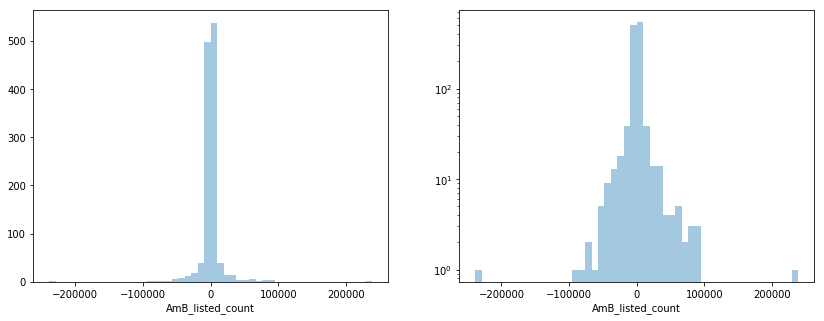

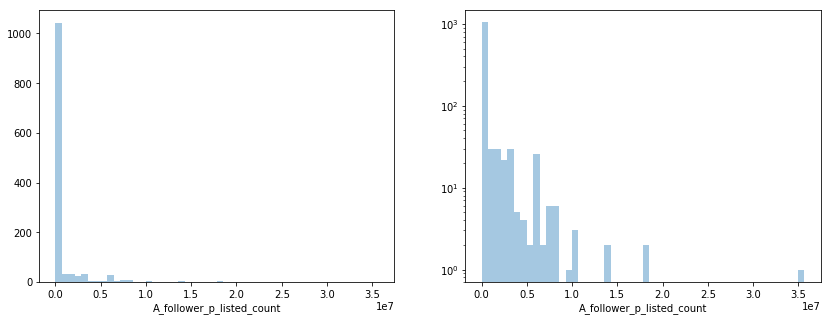

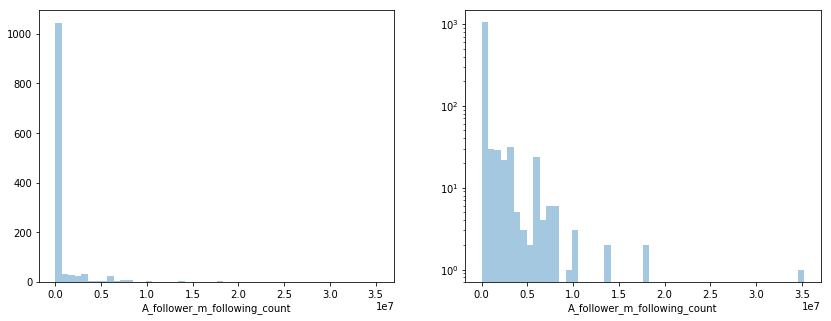

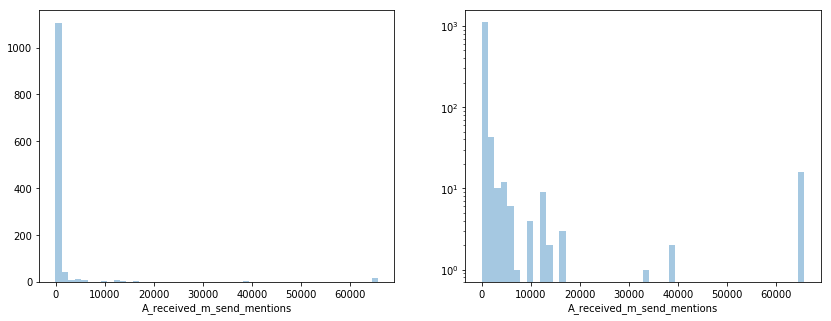

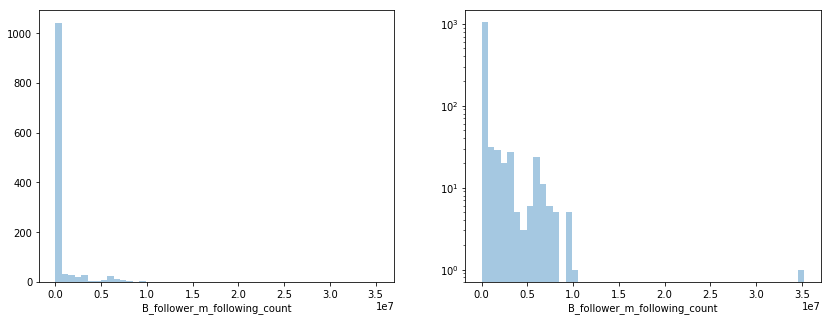

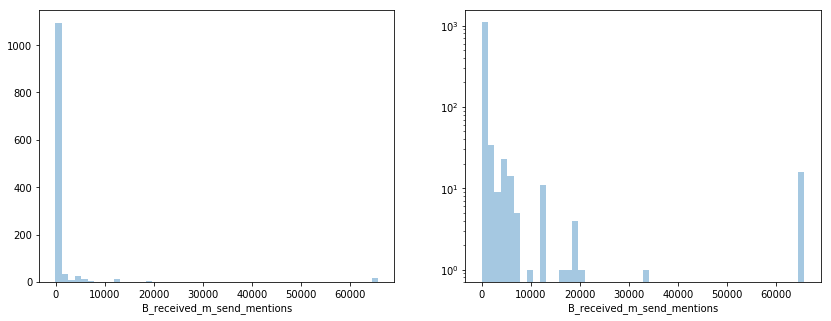

In [5]:
# Plot the features 
for i, col in enumerate(df_x.columns,start=1):
    plt.figure(i,figsize=(14, 5))
    
    feature = df_x[col]

    # distribution of each feature
    plt.subplot(1, 2, 1)
    sns.distplot(feature,kde=False)
    
    # Add log-y plot to better see the low populated regions
    plt.subplot(1, 2, 2)
    ax = sns.distplot(feature,kde=False)
    ax.set_yscale('log')

# Model evaluation

In [6]:
class MLmodel:
    def __init__(self,model,name,model_type = 'importance'):
        self.name = name
        self.model = model
        self.model_type = model_type

In [7]:
models = [
    XGBClassifier(random_state=1,n_estimators=100)
]

MLmodels = [
    MLmodel(models[0],'XGBoost','importance')
]

In [69]:
# Function to evaluate the results using Accuracy and ROC AUC
def evaluate(model,x,y):
    #predict the output
    predictions = model.predict(x)
    predicting_prob = model.predict_proba(x)[:,1]
    
    #Accuracy score
    accuracy = accuracy_score(y_pred=predictions,y_true=y)
    print("Accuracy: {:.3f}% ".format(accuracy*100))
    # ROC AUC score
    roc_auc = roc_auc_score(y_score=predicting_prob,y_true=y)
    print("ROC AUC: {:.3f}% \n".format(roc_auc*100))  

# Run cross-validation
def run_cross_validation(model,name,x_tot,y_tot,cv):
    print('Starting Cross-validation')
    
    #Score using accuracy
    scoresAccuracy=cross_val_score(model,x_tot,y_tot,cv=cv,verbose=1,n_jobs=-1)
    print("CV with accuracy: %0.3f +/- %0.3f" % (scoresAccuracy.mean(), scoresAccuracy.std()))
    
    #Score with AUC
    scoresROCAUC=cross_val_score(model,x_tot,y_tot,cv=cv,scoring='roc_auc',verbose=1,n_jobs=-1)
    print("CV with ROC AUC: %0.3f +/- %0.3f" % (scoresROCAUC.mean(), scoresROCAUC.std()))
    
    #Plot learning curve 
    plot_learning_curve(model,name,x_tot,y_tot,cv=cv,n_jobs=-1)
    plt.show()
    
def advanced_evaluate_model(model,name, x_train, y_train, x_test, y_test, cv):
    # Train the algorithm
    history = model.fit(x_train,y_train)
    #predict the output
    predictions = model.predict(x_test)
    predicting_prob = model.predict_proba(x_test)[:,1]
    
    print(model)
    # Evaluate the results
    print('**********************TRAIN Sample***********************')
    evaluate(model,x_train,y_train)     
    print('***********************TEST Sample***********************')
    evaluate(model,x_test,y_test) 
    
    # Merge test and train samples
    x_tot = pd.concat([x_train,x_test],axis=0)
    y_tot = pd.concat([y_train,y_test],axis=0)

    # If run cross-validation:
    if cv:
        #Cross-validation

        # Splitting strategy
        kfold = RepeatedStratifiedKFold(n_splits=10, n_repeats=4, random_state=1)
    
        run_cross_validation(model,name,x_tot,y_tot,cv=kfold)
    
    # ROC Curve. 
    fpr,tpr,thresh = roc_curve(y_test,predicting_prob)
    plt.figure(figsize=(7,7))
    plt.plot(fpr,tpr,label = ("Area under the curve {:0.3f}".format(auc(fpr,tpr))),color = "r")
    plt.plot([1,0],[1,0],linestyle = "dashed",color ="k")
    plt.legend(loc = "best")
    plt.title(name + " ROC - Curve & Area Under Curve",fontsize=18)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.show()
    
    # plot learning history:
    if name == 'DNN': 
        plot_DNN_training_history(history)
        plt.show()
    
    print('\n\n')
    
    model.fit(x_tot,y_tot)
    
    return model

# function to evaluate the feature importance
def feature_importance(df_ini,model,model_type,model_name):
    # transform the input data, accessing is different for different algorithms, hard coded now. 
    # Should be imporved later
    if model_type == 'importance':
        df = pd.DataFrame(model.feature_importances_,df_ini.columns).reset_index()
    else:
        df = pd.DataFrame(model.coef_.ravel(),df_ini.columns).reset_index()
    df.rename(columns={'index':'features',0:'coefficients'},inplace=True)
    # sort the values
    df.sort_values(by='coefficients',ascending = False,inplace=True)
        
    #plot
    sns.barplot(x = df['coefficients'] ,y = df['features'])    
    plt.title("Feature Importance " + model_name,fontsize=11,fontweight="bold")
    
def fast_feature_importance(df,models):
    df_x = df
    if 'Choice' in df.columns:
        df_x = df.drop(columns=['Choice'])
    # Analyse feature importance
    plt.figure(figsize=(15,15))
    plt.subplots_adjust(wspace=0.5)
    for i, model in enumerate(models,start=1):
        plt.subplot(2,2,i)
        feature_importance(df_x,model.model,model.model_type,model.name)
        
# function from 
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [9]:
# Columns to be dropped for the evaluation:
drop_eval = ['A_unique_id','B_unique_id']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 89.495% 
ROC AUC: 95.979% 

***********************TEST Sample***********************
Accuracy: 67.078% 
ROC AUC: 75.309% 

Starting Cross-validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV with accuracy: 0.709 +/- 0.034


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished


CV with ROC AUC: 0.787 +/- 0.032


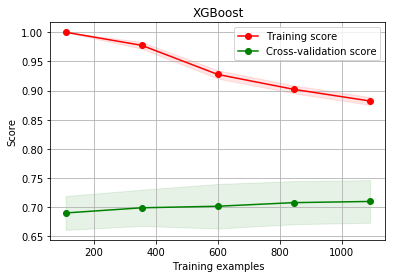

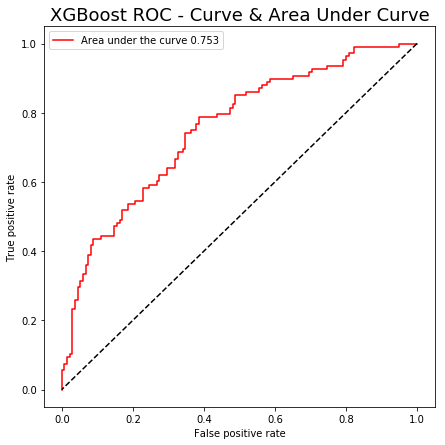

In [10]:
model_res = {}
x_train, x_test, y_train, y_test = train_test_split(df_x.drop(columns=drop_eval), df_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

# Dimensionality reduction

## Low Variance Filter

In [11]:
df_x.var()

B_interactions_count            3.142323e+02
B_unique_id                     5.049628e+04
A_interactions_count            3.040720e+02
A_unique_id                     1.507848e+05
A_follower_count                3.928359e+12
A_following_count               2.153946e+09
A_listed_count                  2.018369e+08
A_mentions_received             6.151608e+07
A_retweets_received             1.409603e+07
A_mentions_sent                 3.617829e+01
A_retweets_sent                 2.158925e+00
A_posts                         8.947446e+01
A_network_feature_1             4.864610e+08
A_network_feature_2             1.412101e+04
A_network_feature_3             4.445607e+07
B_follower_count                3.447925e+12
B_following_count               1.162448e+09
B_listed_count                  1.753755e+08
B_mentions_received             6.059287e+07
B_retweets_received             1.477759e+07
B_mentions_sent                 3.368732e+01
B_retweets_sent                 1.851305e+00
B_posts   

* Hard to draw any conclusion from these numbers. Further investigation is needed

## High Correlation filter

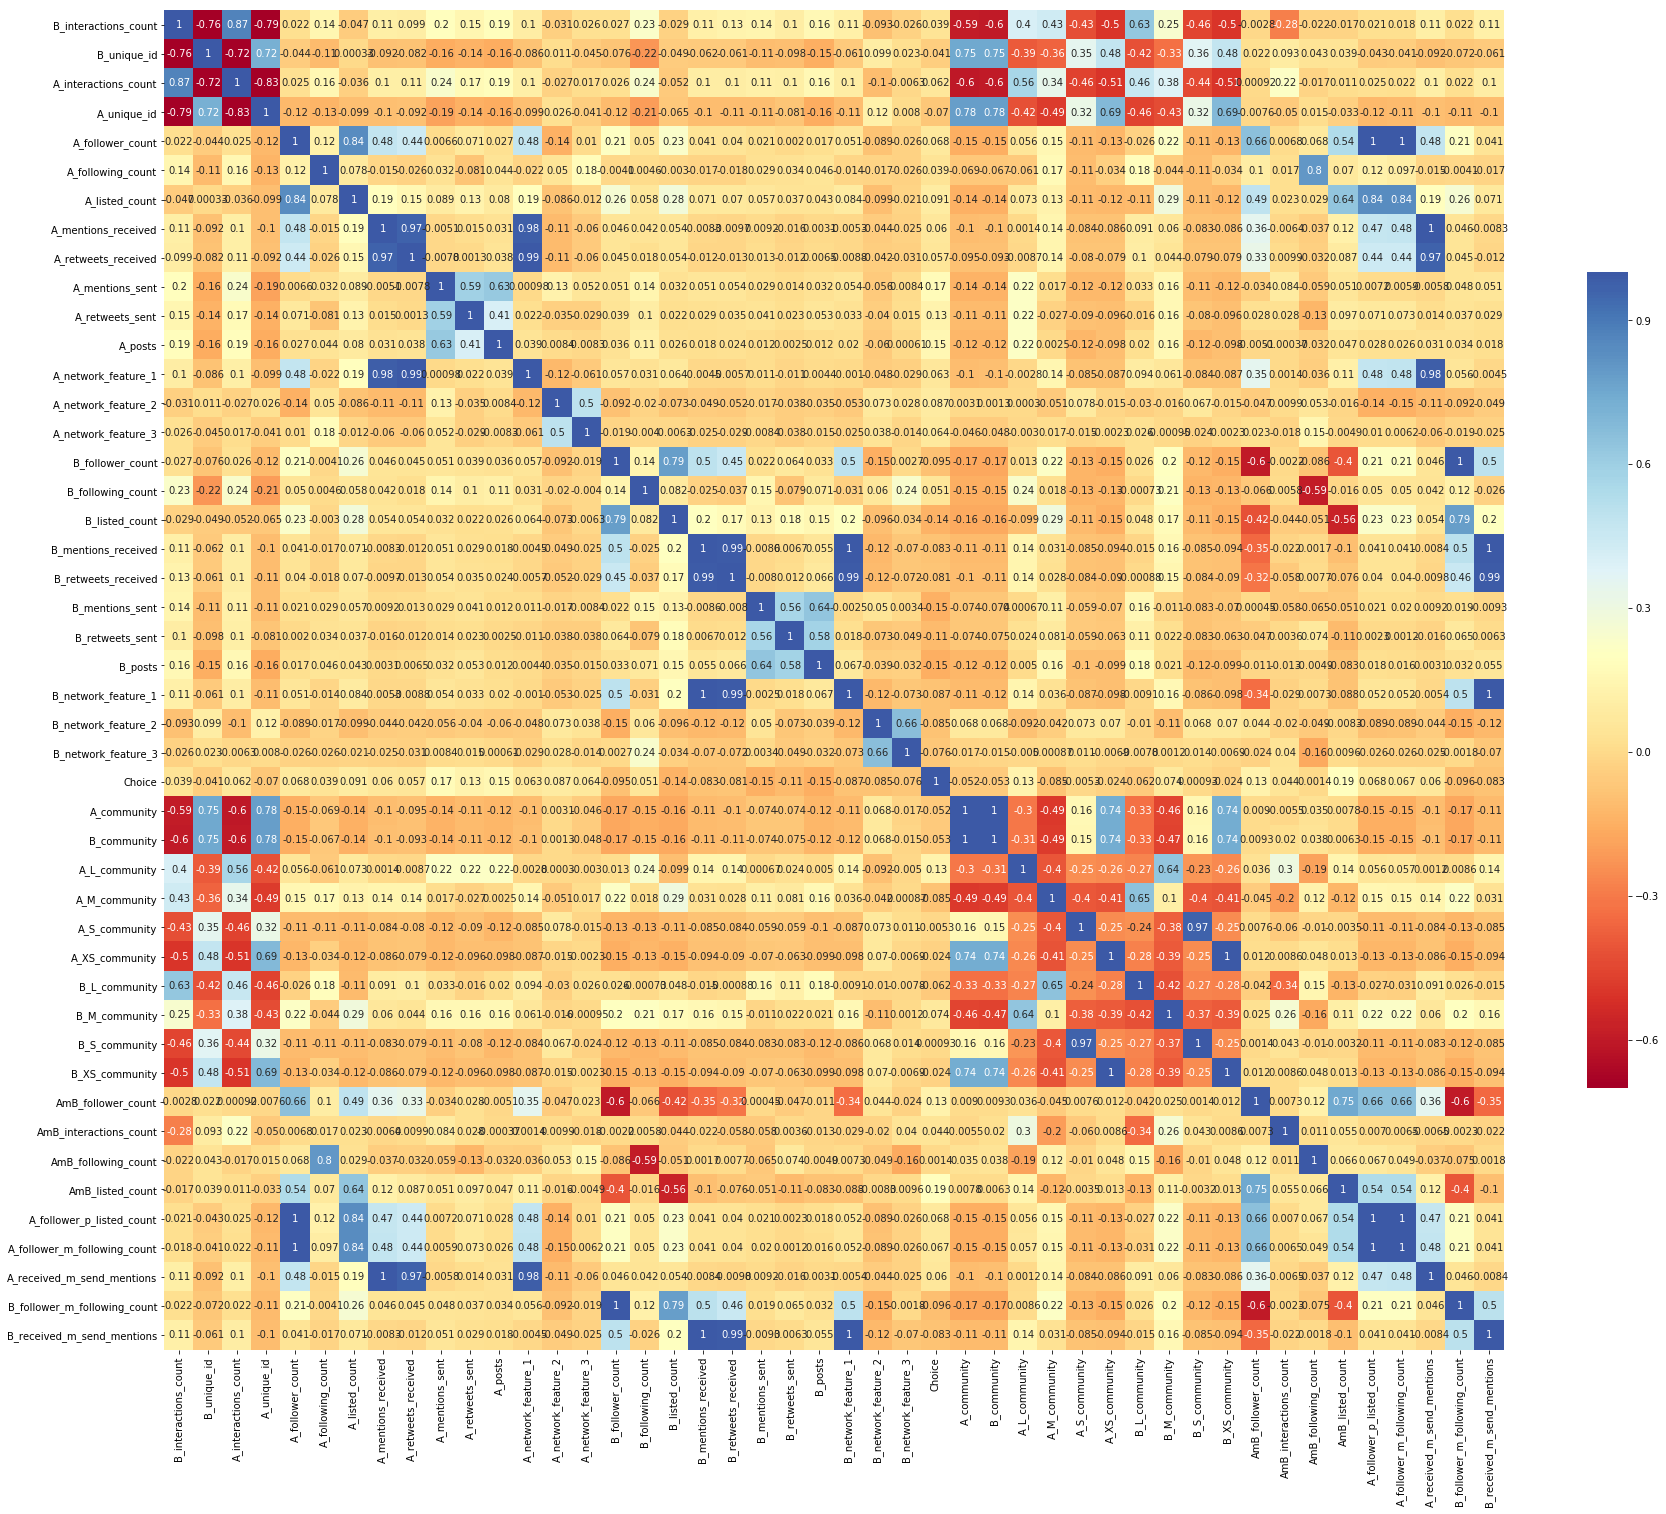

In [12]:
corr = df.corr()
plt.subplots(figsize=(30, 30))
cmap = sns.diverging_palette(150, 250, as_cmap=True)
sns.heatmap(corr, cmap="RdYlBu", vmax=1, vmin=-0.7, center=0.2, square=True, linewidths=0, cbar_kws={"shrink": .5}, annot = True);

* Drop features with coefficeint > 0.9

In [13]:
drop_highly_corr = ['A_network_feature_1','B_network_feature_1','A_XS_community','A_mentions_received','B_mentions_received']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 89.392% 
ROC AUC: 96.284% 

***********************TEST Sample***********************
Accuracy: 68.724% 
ROC AUC: 74.787% 

Starting Cross-validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV with accuracy: 0.709 +/- 0.035


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.2s finished


CV with ROC AUC: 0.786 +/- 0.032


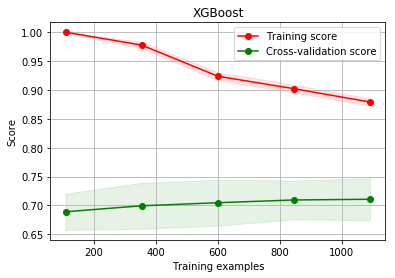

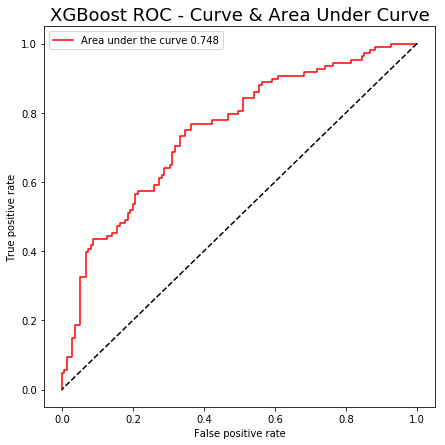

In [14]:
#Check performance
model_res = {}
x_train, x_test, y_train, y_test = train_test_split(df_x.drop(columns=drop_highly_corr + drop_eval), df_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

# Feature importance

## Backward Feature Selection: RFECV

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 89.495% 
ROC AUC: 95.979% 

***********************TEST Sample***********************
Accuracy: 67.078% 
ROC AUC: 75.309% 

Starting Cross-validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV with accuracy: 0.709 +/- 0.034


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.6s finished


CV with ROC AUC: 0.787 +/- 0.032


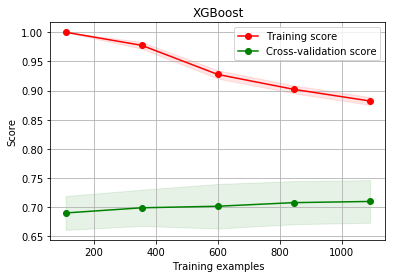

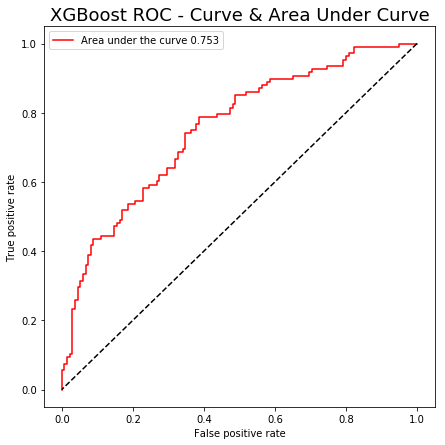

In [15]:
# Run again to reset the model
model_res = {}
x_train, x_test, y_train, y_test = train_test_split(df_x.drop(columns=drop_eval), df_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

In [16]:
from sklearn.feature_selection import RFECV

selector = RFECV(MLmodels[0].model, step=1, cv=5)
selector.fit(df_x,df.Choice)

RFECV(cv=5,
   estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
   min_features_to_select=1, n_jobs=None, scoring=None, step=1, verbose=0)

features  Grid_Scores  Ranking
23           B_network_feature_1     0.695975      1.0
6                 A_listed_count     0.695212      1.0
41  A_follower_m_following_count     0.696852      1.0
1                    B_unique_id     0.654012      1.0
17                B_listed_count     0.700977      1.0

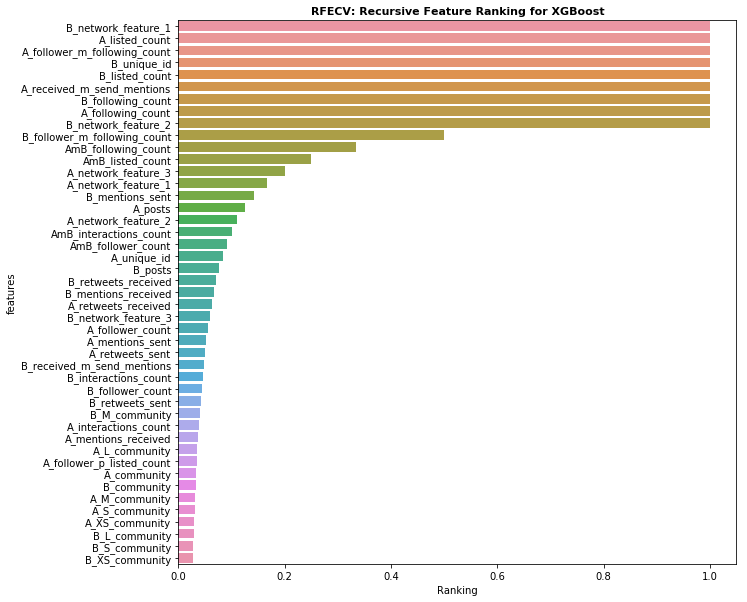

In [17]:
#Ranking transformation for the visualisaiton:
ranking = 1./selector.ranking_
ranking_df = pd.DataFrame(data={0:selector.grid_scores_,1:ranking},index = df_x.columns).reset_index()
#rename the columns
ranking_df.rename(columns={'index':'features',0:'Grid_Scores',1:'Ranking'},inplace=True)
# sort the values
ranking_df.sort_values(by='Ranking',ascending = False,inplace=True)
# Plot
plt.figure(figsize=(10,10))
sns.barplot(x = ranking_df.Ranking ,y = ranking_df.features)    
plt.title("RFECV: Recursive Feature Ranking for " + MLmodels[0].name,fontsize=11,fontweight="bold")
ranking_df.head()

## Standard Feature Importance

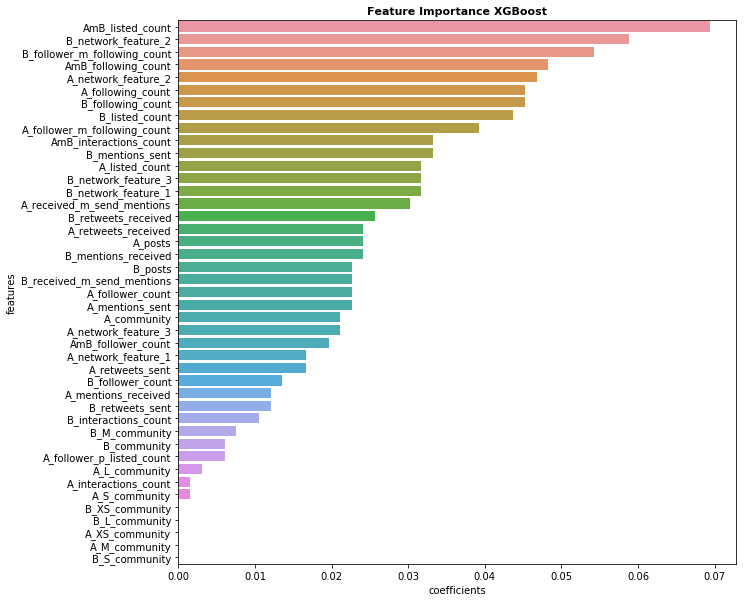

In [18]:
plt.figure(figsize=(10,10))
feature_importance(df_x.drop(columns=drop_eval),MLmodels[0].model,model_name=MLmodels[0].name,model_type=MLmodels[0].model_type)

## XGBoost feature importance (built-in)

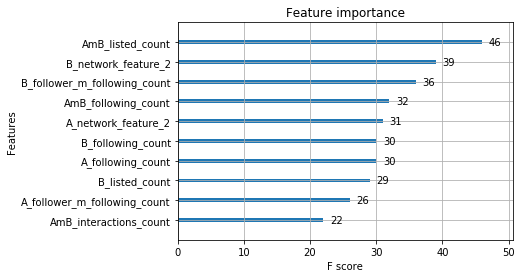

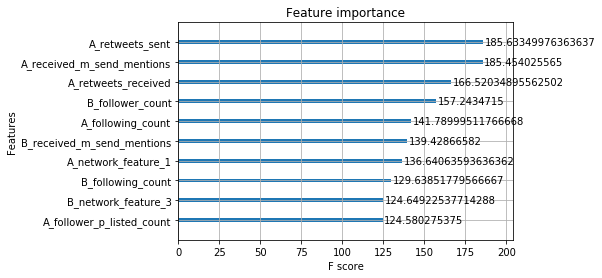

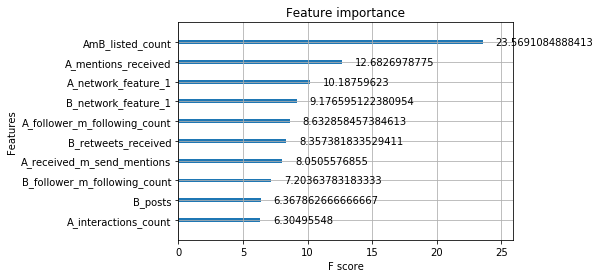

In [19]:
#weight - The number of times a feature is used to split the data across all trees.
plot_importance(MLmodels[0].model,importance_type='weight',max_num_features=10)
#cover - The number of times a feature is used to split the data across all trees weighted by the number of training data points that go through those splits.
plot_importance(MLmodels[0].model,importance_type='cover',max_num_features=10)
#gain - The average training loss reduction gained when using a feature for splitting.
plot_importance(MLmodels[0].model,importance_type='gain',max_num_features=10)

### Plot tree

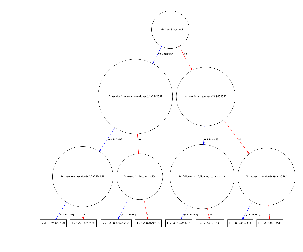

In [20]:
ax = plot_tree(MLmodels[0].model)

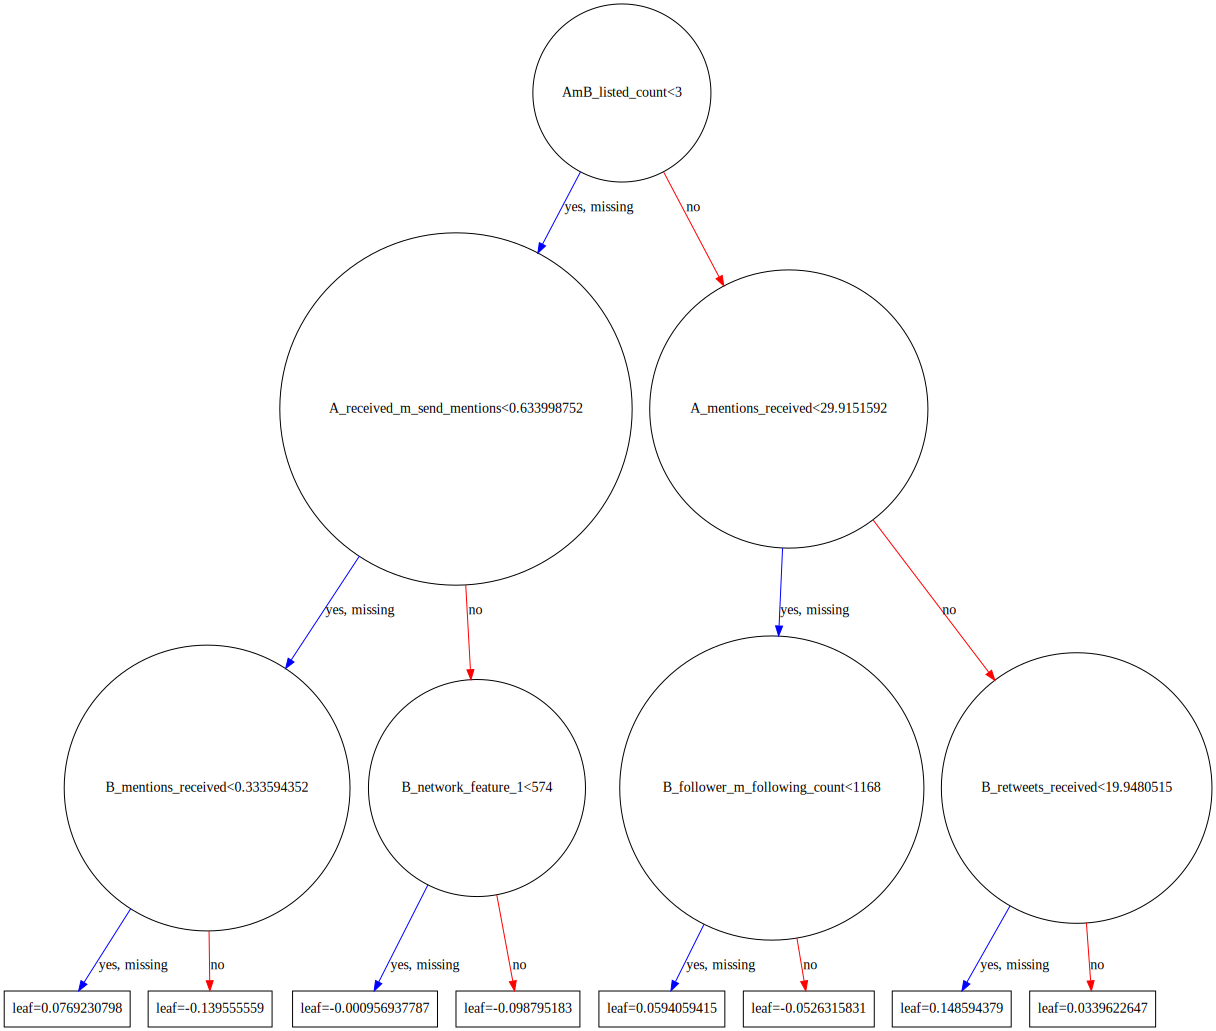

In [21]:
to_graphviz(MLmodels[0].model)

## Forward Feature Selection: f_classif

In [22]:
from sklearn.feature_selection import SelectPercentile, f_classif

selector = SelectPercentile(f_classif,percentile=10) # set percentile to 10, but for the Feature Importance plot it doesn't really matter
selector.fit(df_x,df_y)

SelectPercentile(percentile=10,
         score_func=<function f_classif at 0x1a16006e18>)

features      p-values     Scores
39  AmB_listed_count  1.660644e-11  46.212794
9    A_mentions_sent  2.314361e-09  36.235052
22           B_posts  5.738353e-08  29.822949
11           A_posts  1.132140e-07  28.474683
20   B_mentions_sent  3.074420e-07  26.498705

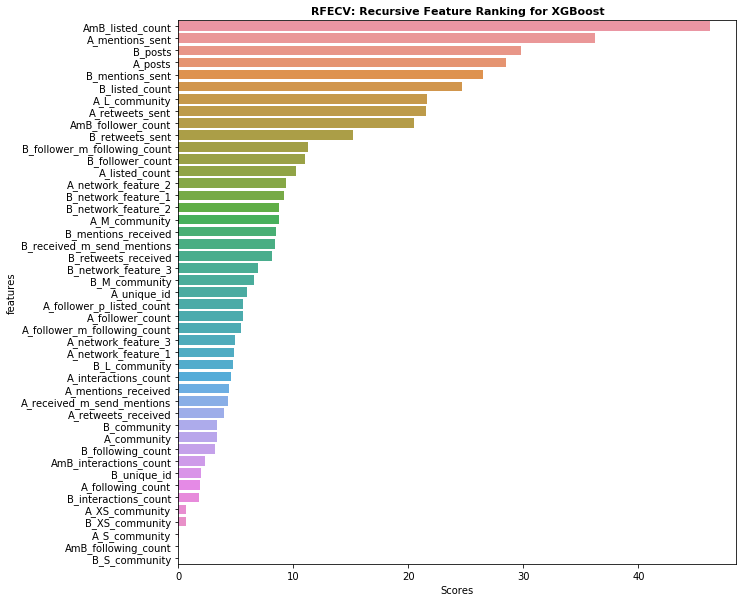

In [23]:
#Ranking transformation for the visualisaiton:
ranking = selector.scores_
ranking_df = pd.DataFrame(data={0:selector.pvalues_,1:ranking},index = df_x.columns).reset_index()
#rename the columns
ranking_df.rename(columns={'index':'features',0:'p-values',1:'Scores'},inplace=True)
# sort the values
ranking_df.sort_values(by='Scores',ascending = False,inplace=True)
# Plot
plt.figure(figsize=(10,10))
sns.barplot(x = ranking_df.Scores ,y = ranking_df.features)    
plt.title("RFECV: Recursive Feature Ranking for " + MLmodels[0].name,fontsize=11,fontweight="bold")
ranking_df.head()

In [24]:
from sklearn.pipeline import Pipeline
# #############################################################################
# Create a feature-selection transform and an instance of XGBOOST that we
# combine together to have an full-blown estimator
CLF = Pipeline([('anova', selector), (MLmodels[0].name, MLmodels[0].model)])

# #############################################################################
# Plot the cross-validation score as a function of percentile of features
score_means = list()
score_stds = list()
percentiles = (1,2,3,5, 10, 15, 20, 30, 40, 50, 60, 80, 100)

for percentile in percentiles:
    CLF.set_params(anova__percentile=percentile)
    this_scores = cross_val_score(CLF, df_x.drop(columns=drop_eval), df_y, cv=5, n_jobs=-1)
    score_means.append(this_scores.mean())
    score_stds.append(this_scores.std())

Text(0, 0.5, 'Prediction rate')

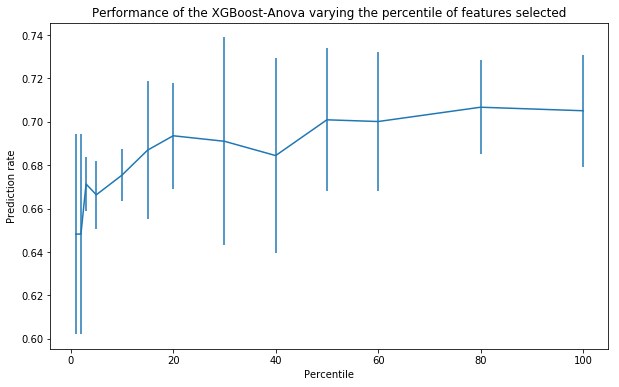

In [25]:
# Plot
plt.figure(figsize=(10,6))
plt.errorbar(percentiles, score_means, np.array(score_stds))
plt.title(
    'Performance of the XGBoost-Anova varying the percentile of features selected')
plt.xlabel('Percentile')
plt.ylabel('Prediction rate')

## SHAP - SHapley Additive exPlanations

The **Shapley value** - a method from coalitional game theory - tells us how to fairly distribute the ‘payout’ or credit among the features.

Meeting the following conditions will mean the game is ‘fair’ according to Shapley values:
* The sum of what everyone receives should equal the total reward .
* If 2 people contributed the same value, then they should receive the same amount from the reward.
* Someone who contributed no value should receive nothing.
* If the group plays two games, then an individual’s reward from both games should equal their reward from their first game plus their reward from the second game

**SHapley Additive exPlanations** – explains the output of any machine learning model using Shapley values, used in the feature importance context.

In [26]:
import shap
explainer = shap.TreeExplainer(MLmodels[0].model)
shap_values = explainer.shap_values(df_x.drop(columns=drop_eval))

In [27]:
# load JS visualization code to notebook
shap.initjs()
# visualize the first prediction's explanation
shap.force_plot(explainer.expected_value, shap_values[12,:], df_x.drop(columns=drop_eval).iloc[12,:])

* The above explanation shows features each contributing to push the model output from the base value (the average model output over the training dataset we passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue 
* If we take many explanations such as the one shown above, rotate them 90 degrees, and then stack them horizontally, we can see explanations for an entire dataset (in the notebook this plot is interactive):

In [28]:
# visualize the training set predictions
shap.force_plot(explainer.expected_value, shap_values[:10], df_x.drop(columns=drop_eval)[:10])

To understand how a single feature effects the output of the model we can plot the SHAP value of that feature vs. the value of the feature for all the examples in a dataset. Since SHAP values represent a feature's responsibility for a change in the model output, the plot below represents the change in **A-B listed_count**. Vertical dispersion at a single value represents interaction effects with other features. To help reveal these interactions dependence_plot automatically selects another feature for coloring. In this case coloring by **B_listed_count** highlights that the average number of rooms per house has less impact on home price for areas close to radial highways.

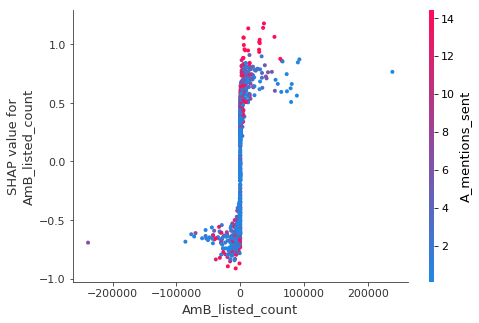

In [29]:
# create a SHAP dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("AmB_listed_count", shap_values, df_x.drop(columns=drop_eval))

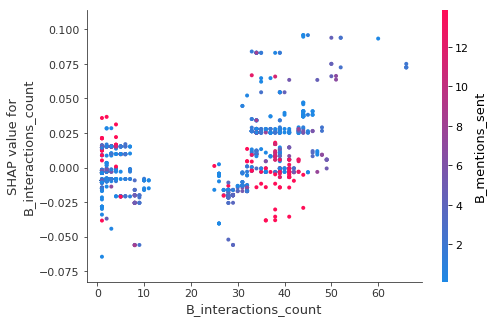

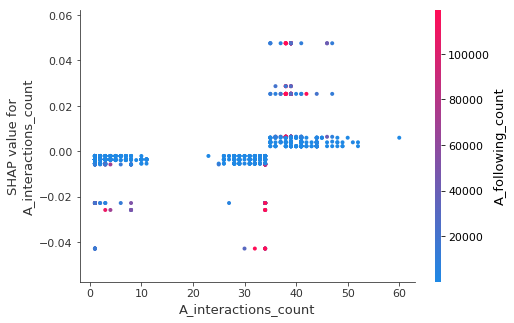

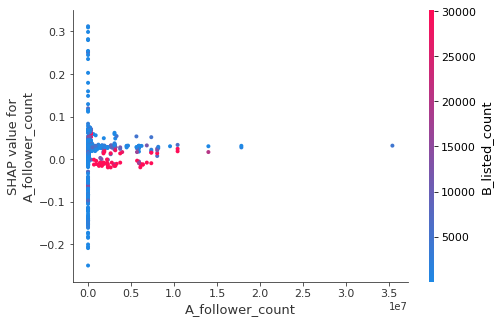

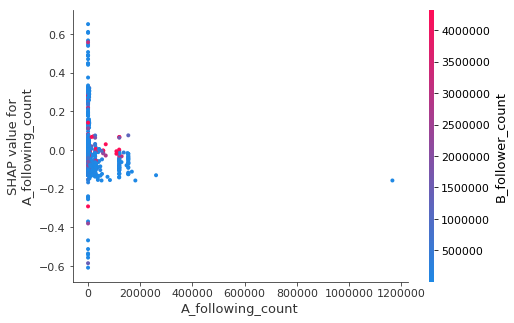

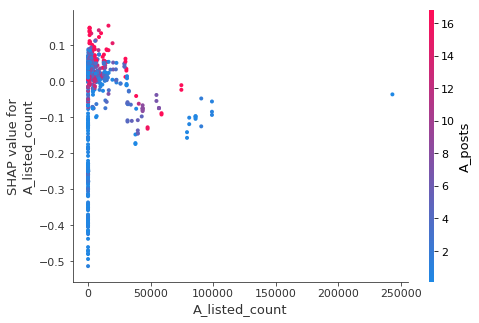

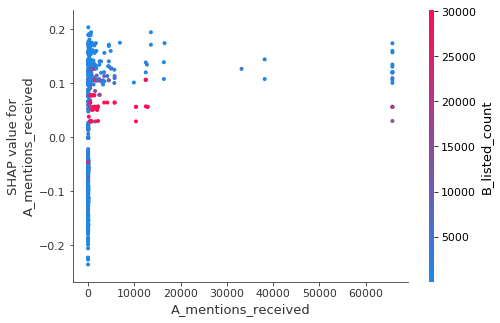

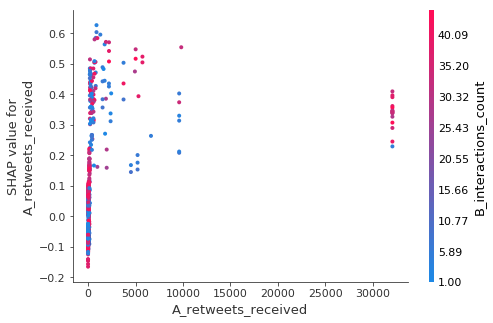

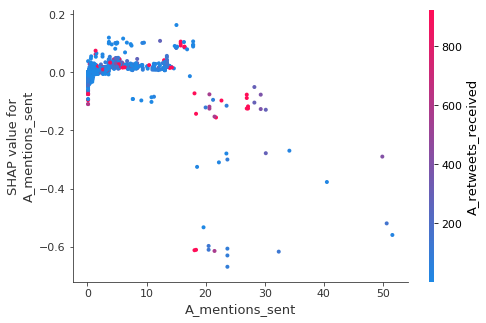

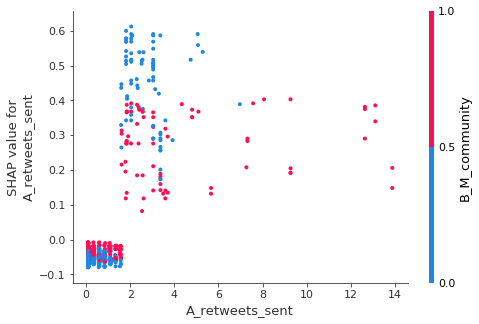

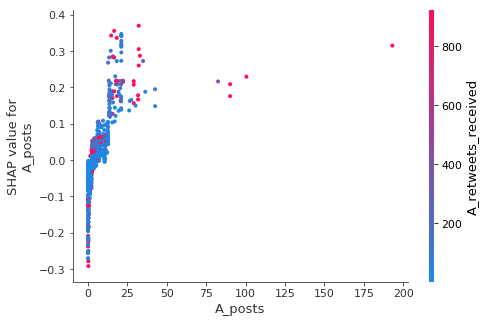

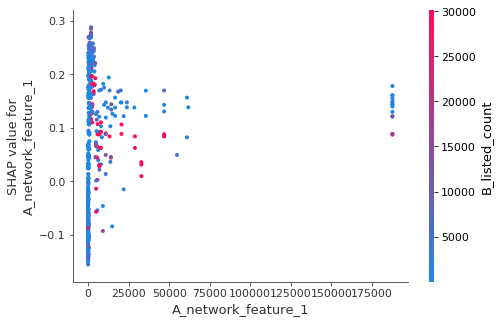

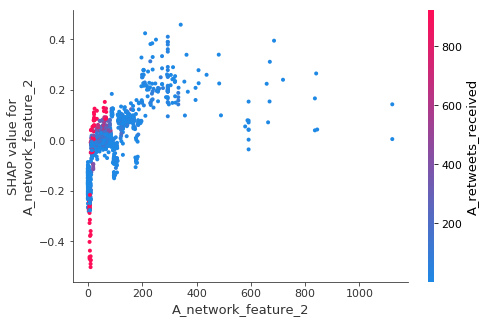

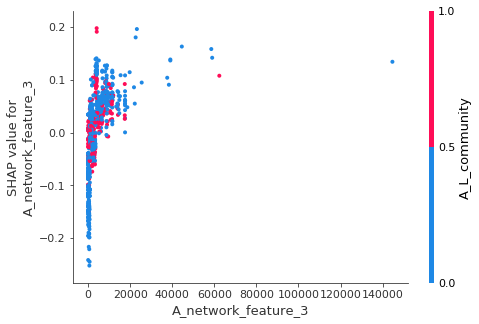

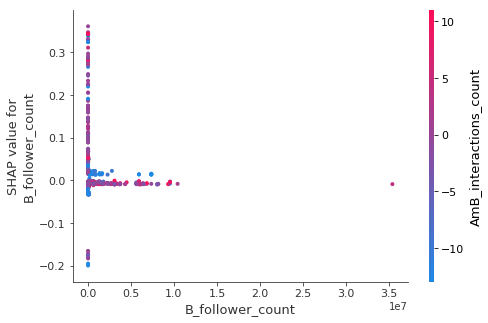

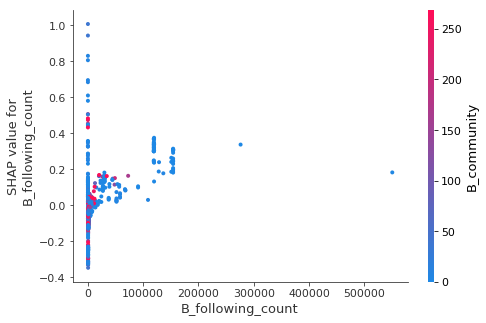

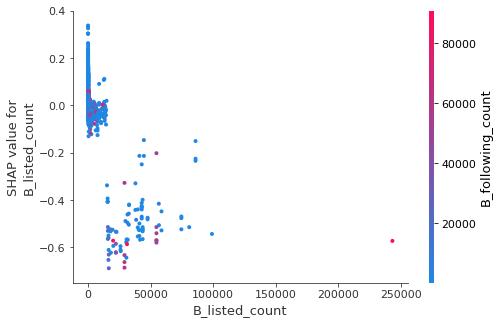

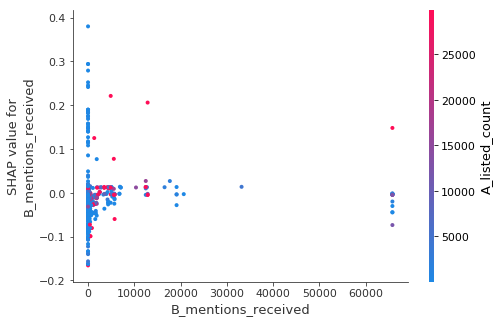

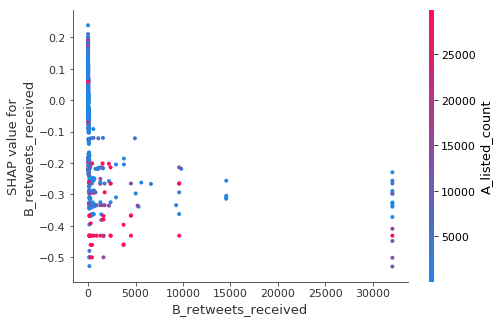

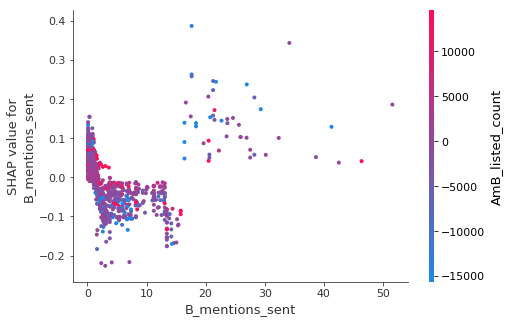

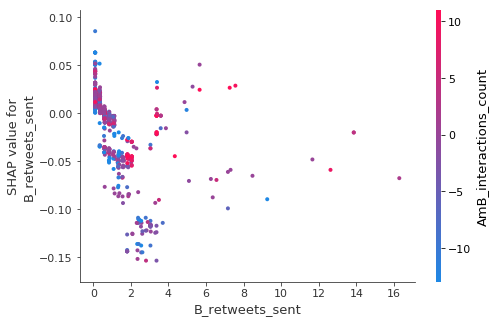

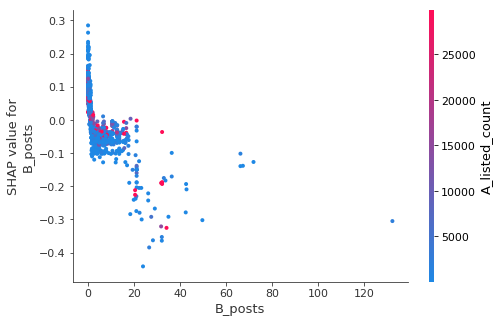

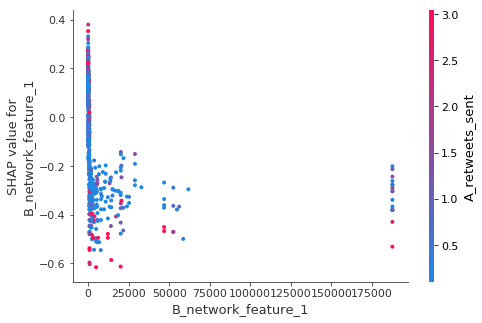

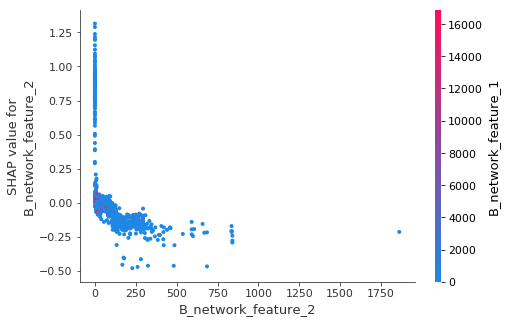

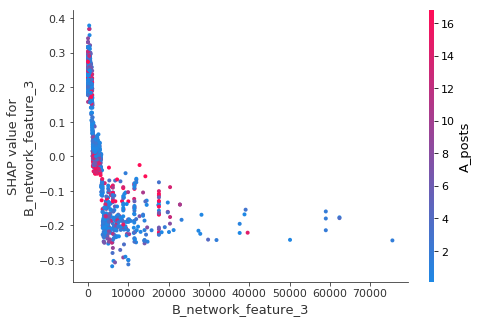

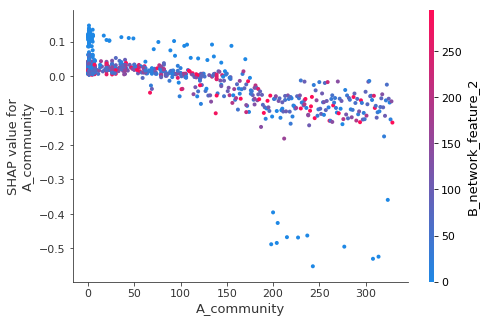

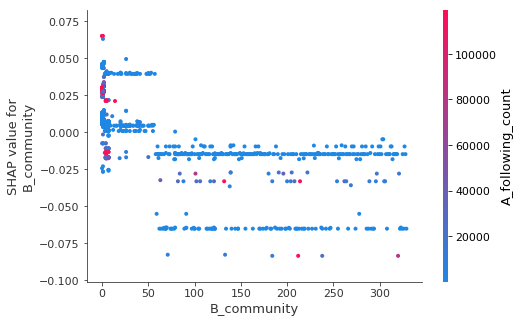

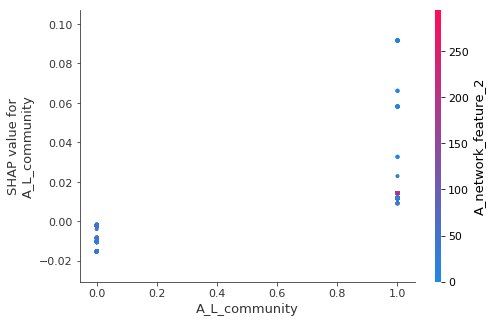

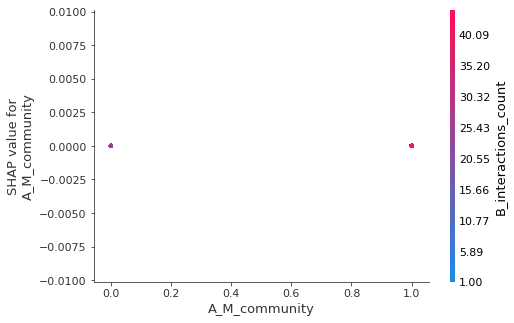

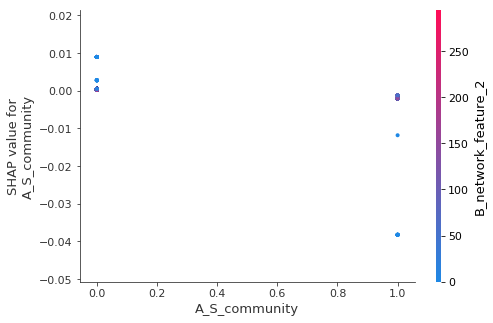

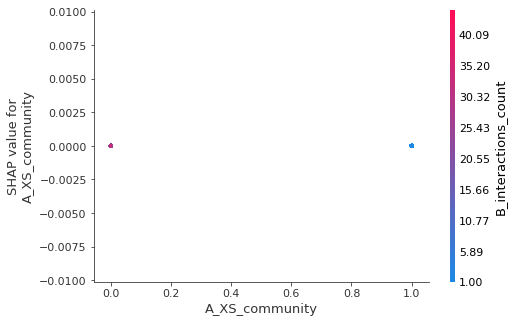

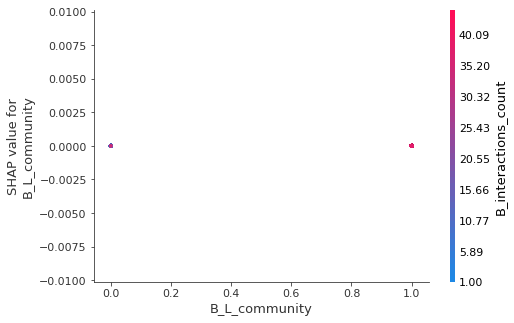

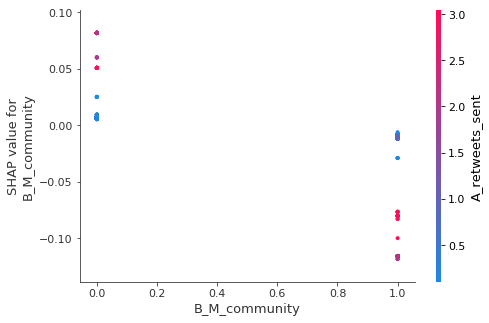

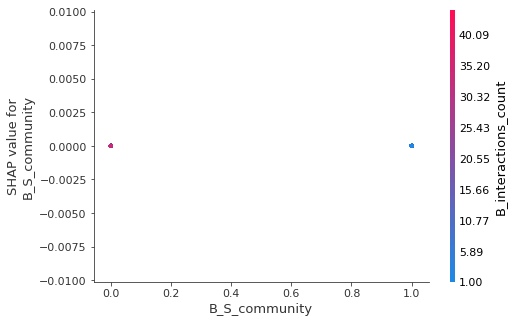

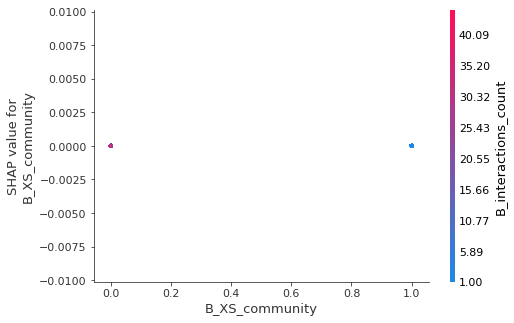

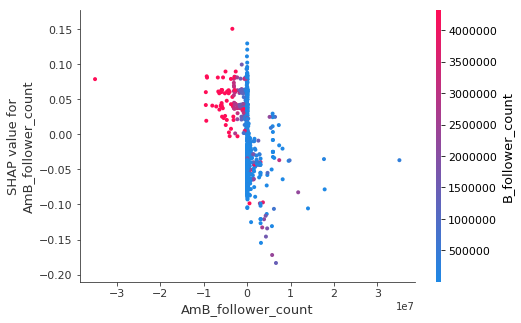

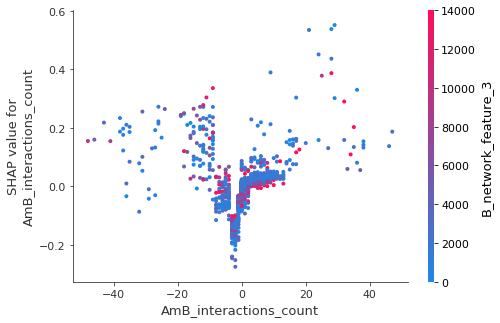

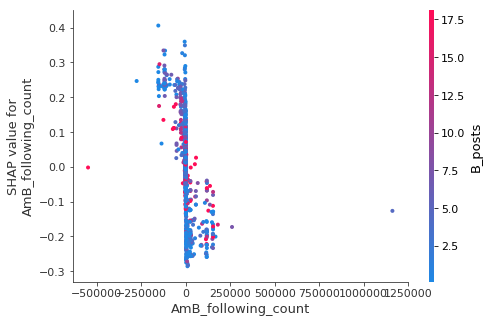

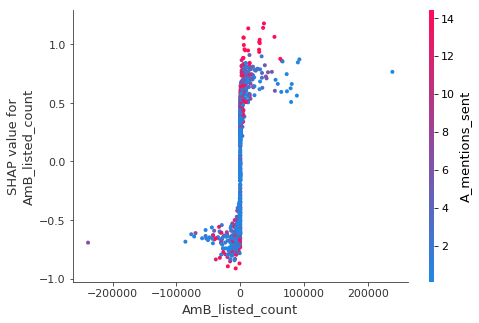

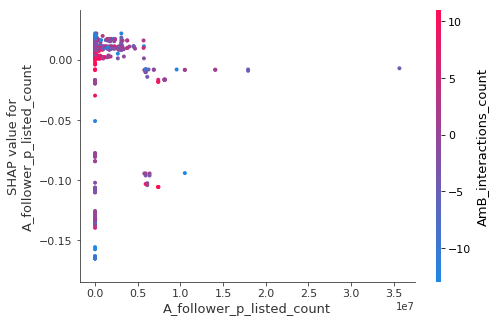

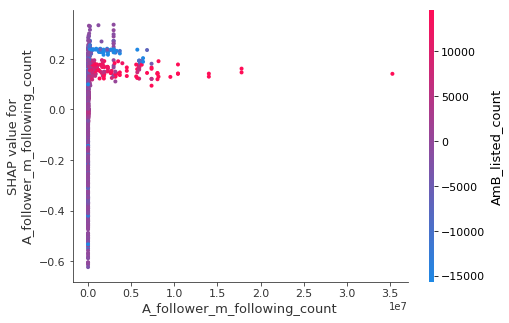

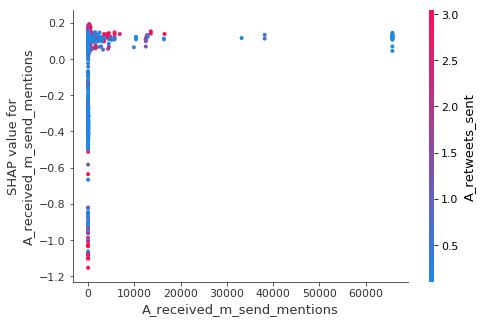

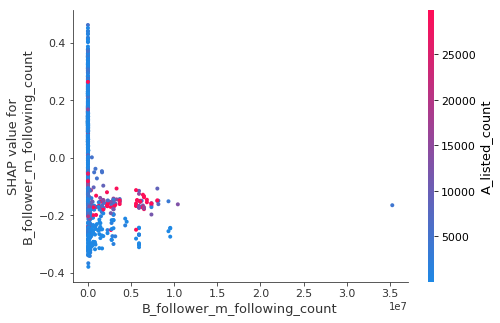

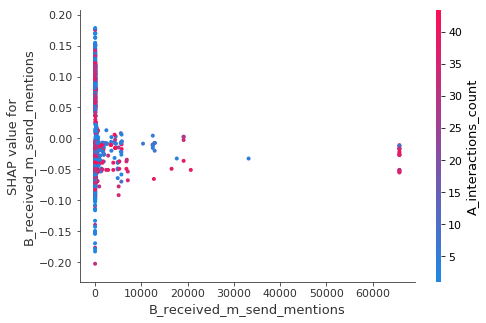

In [30]:
for col in df_x.drop(columns=drop_eval).columns:
    shap.dependence_plot(col, shap_values, df_x.drop(columns=drop_eval))

### SHAP summary plot

To get an overview of which features are most important for a model we can plot the SHAP values of every feature for every sample. The plot below sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color represents the feature value (red high, blue low). 

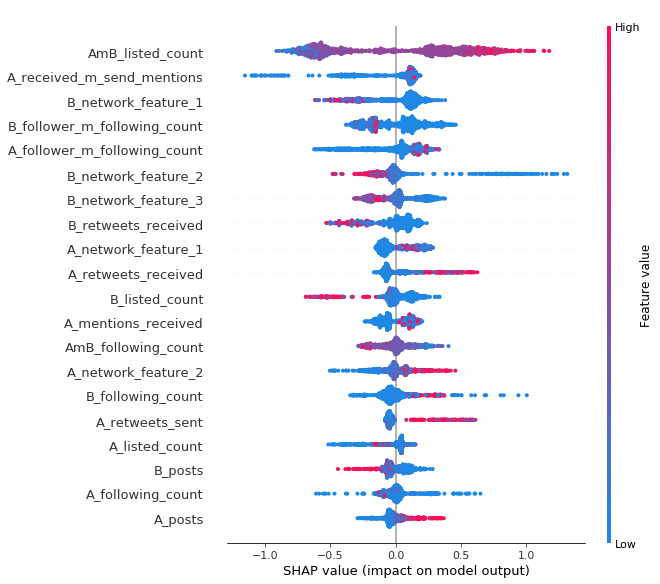

In [31]:
# summarize the effects of all the features
shap.summary_plot(shap_values, df_x.drop(columns=drop_eval))

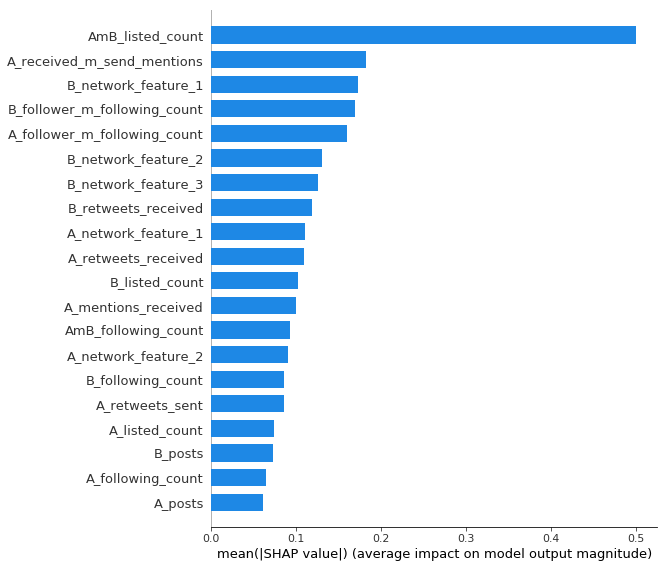

In [32]:
shap.summary_plot(shap_values, df_x.drop(columns=drop_eval), plot_type="bar")

### SHAP Interaction Values

SHAP interaction values are a generalization of SHAP values to higher order interactions. Fast exact computation of pairwise interactions are implemented for tree models with shap.TreeExplainer(model).shap_interaction_values(X). This returns a matrix for every prediction, where the main effects are on the diagonal and the interaction effects are off-diagonal. These values often reveal interesting hidden relationships:

In [33]:
shap_interaction_values = explainer.shap_interaction_values(df_x.drop(columns=drop_eval))

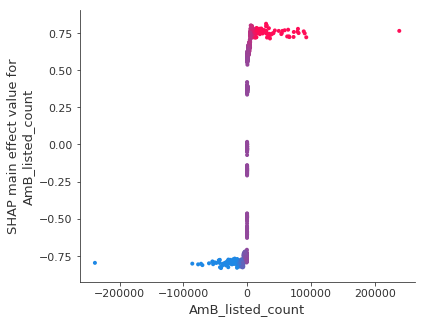

In [34]:
shap.dependence_plot(
    ("AmB_listed_count", "AmB_listed_count"),
    shap_interaction_values, df_x.drop(columns=drop_eval),
    display_features=df_x.drop(columns=drop_eval)
)

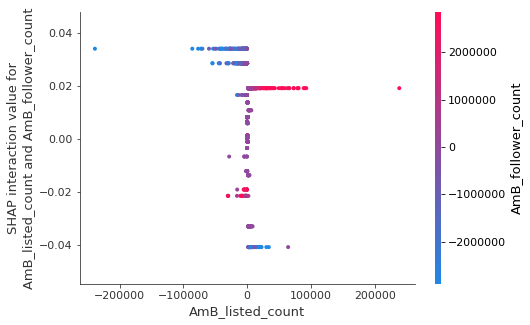

In [35]:
shap.dependence_plot(
    ("AmB_listed_count", "AmB_follower_count"),
    shap_interaction_values, df_x.drop(columns=drop_eval),
    display_features=df_x.drop(columns=drop_eval)
)

# Model optimisation 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 74.974% 
ROC AUC: 85.498% 

***********************TEST Sample***********************
Accuracy: 66.255% 
ROC AUC: 68.687% 

Starting Cross-validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV with accuracy: 0.684 +/- 0.036


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.5s finished


CV with ROC AUC: 0.727 +/- 0.045


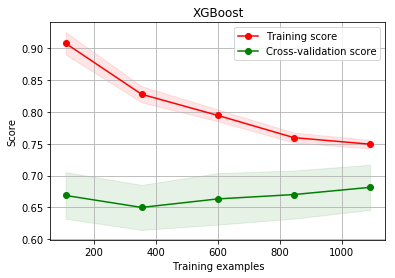

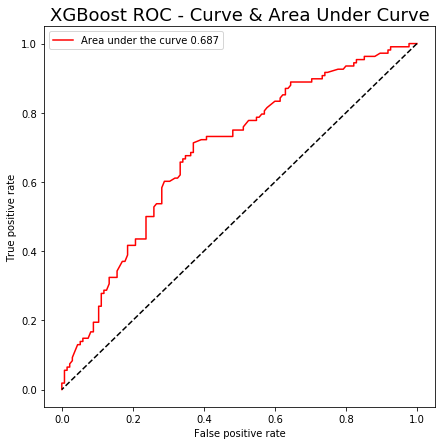

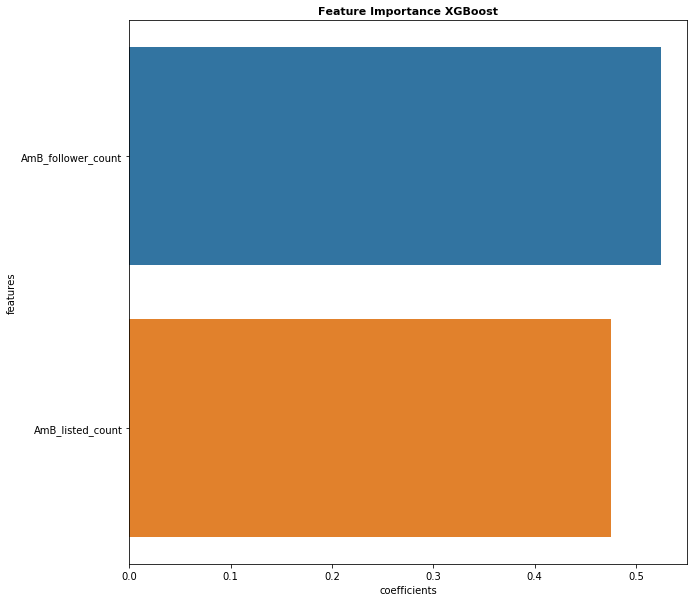

In [36]:
# Run again to reset the model
model_res = {}
# Columns
cols = ['AmB_listed_count','AmB_follower_count']
x_train, x_test, y_train, y_test = train_test_split(df_x[cols], df_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

plt.figure(figsize=(10,10))
feature_importance(df_x[cols],MLmodels[0].model,model_name=MLmodels[0].name,model_type=MLmodels[0].model_type)    

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 80.433% 
ROC AUC: 89.511% 

***********************TEST Sample***********************
Accuracy: 66.255% 
ROC AUC: 71.626% 

Starting Cross-validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV with accuracy: 0.687 +/- 0.036


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    0.7s finished


CV with ROC AUC: 0.767 +/- 0.034


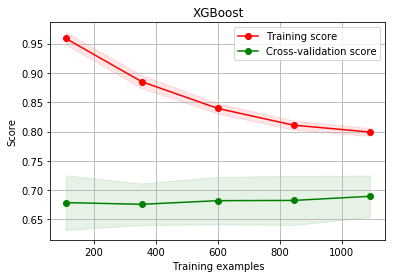

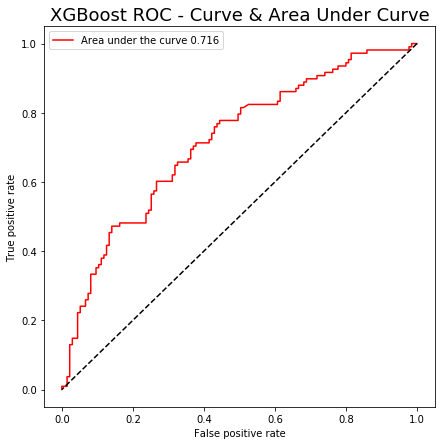

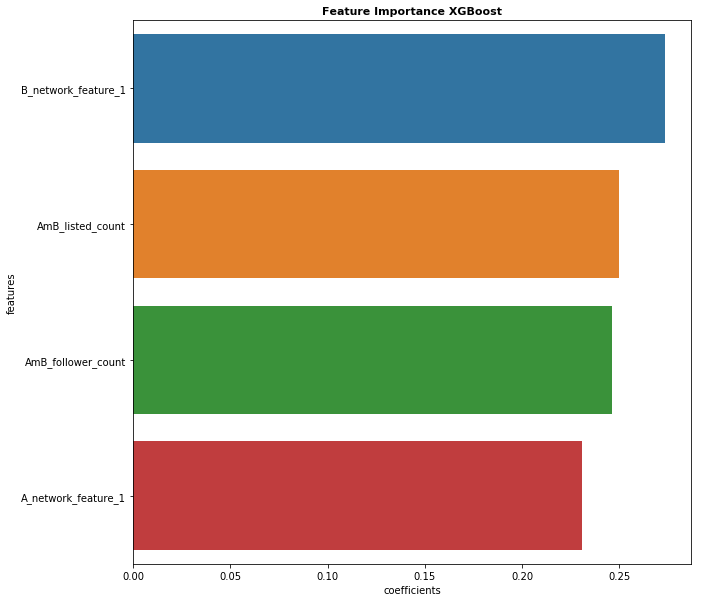

In [37]:
# Run again to reset the model
model_res = {}
# Columns
cols = ['AmB_listed_count','AmB_follower_count','B_network_feature_1','A_network_feature_1']
x_train, x_test, y_train, y_test = train_test_split(df_x[cols], df_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

plt.figure(figsize=(10,10))
feature_importance(df_x[cols],MLmodels[0].model,model_name=MLmodels[0].name,model_type=MLmodels[0].model_type)    

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 83.419% 
ROC AUC: 91.959% 

***********************TEST Sample***********************
Accuracy: 68.724% 
ROC AUC: 76.643% 

Starting Cross-validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV with accuracy: 0.714 +/- 0.035


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.0s finished


CV with ROC AUC: 0.793 +/- 0.033


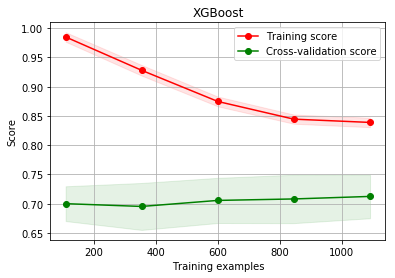

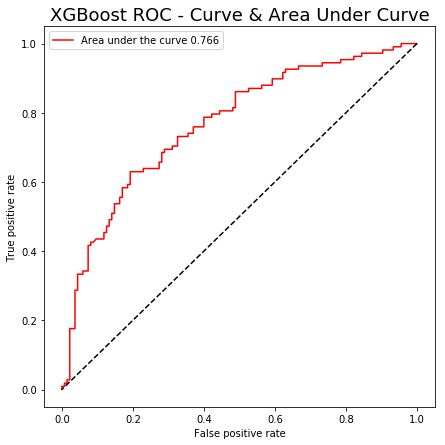

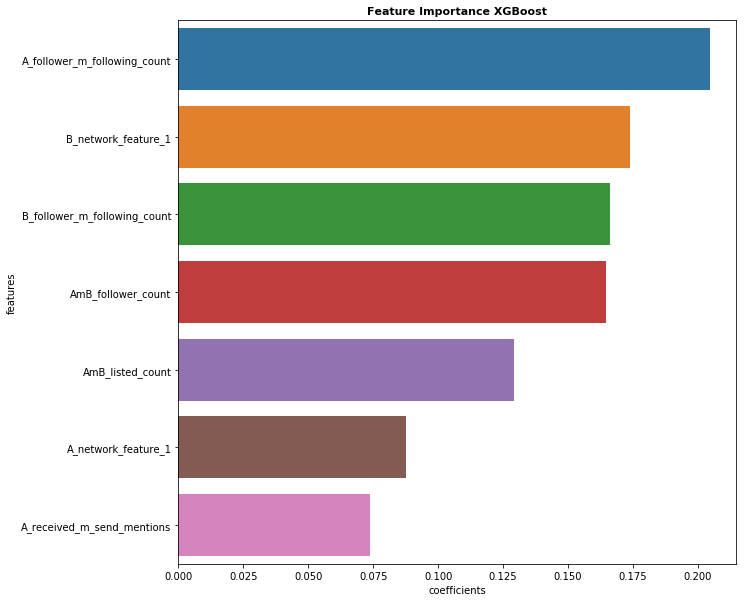

In [38]:
# Run again to reset the model
model_res = {}
# Columns
cols = ['AmB_listed_count','AmB_follower_count','B_network_feature_1','A_network_feature_1','A_follower_m_following_count','B_follower_m_following_count','A_received_m_send_mentions']
x_train, x_test, y_train, y_test = train_test_split(df_x[cols], df_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

plt.figure(figsize=(10,10))
feature_importance(df_x[cols],MLmodels[0].model,model_name=MLmodels[0].name,model_type=MLmodels[0].model_type)    

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 88.568% 
ROC AUC: 95.527% 

***********************TEST Sample***********************
Accuracy: 69.547% 
ROC AUC: 76.262% 

Starting Cross-validation


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    4.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


CV with accuracy: 0.708 +/- 0.036


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    3.8s finished


CV with ROC AUC: 0.787 +/- 0.033


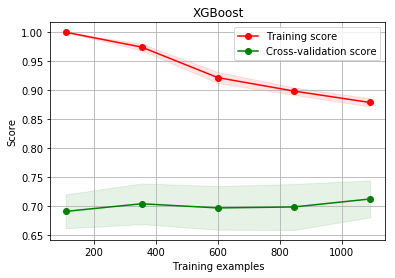

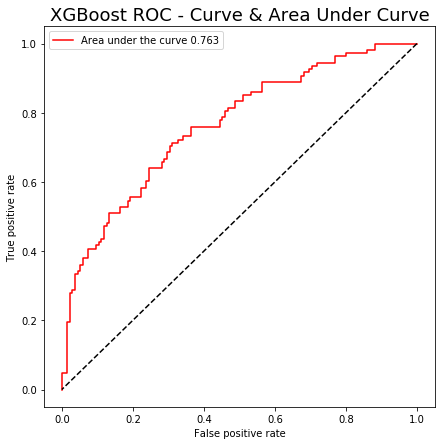

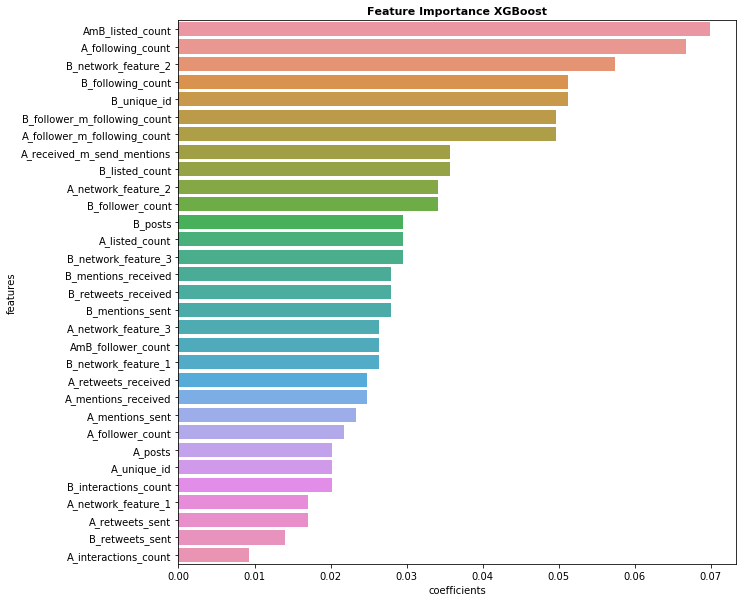

In [39]:
cols = ['B_interactions_count', 'B_unique_id', 'A_interactions_count',
       'A_unique_id', 'A_follower_count', 'A_following_count',
       'A_listed_count', 'A_mentions_received', 'A_retweets_received',
       'A_mentions_sent', 'A_retweets_sent', 'A_posts', 'A_network_feature_1',
       'A_network_feature_2', 'A_network_feature_3', 'B_follower_count',
       'B_following_count', 'B_listed_count', 'B_mentions_received',
       'B_retweets_received', 'B_mentions_sent', 'B_retweets_sent', 'B_posts',
       'B_network_feature_1', 'B_network_feature_2', 'B_network_feature_3',
       'AmB_listed_count','AmB_follower_count','A_follower_m_following_count',
        'B_follower_m_following_count','A_received_m_send_mentions']
x_train, x_test, y_train, y_test = train_test_split(df_x[cols], df_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,True)

plt.figure(figsize=(10,10))
feature_importance(df_x[cols],MLmodels[0].model,model_name=MLmodels[0].name,model_type=MLmodels[0].model_type)    

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.02, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=50,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 75.798% 
ROC AUC: 83.499% 

***********************TEST Sample***********************
Accuracy: 69.959% 
ROC AUC: 74.475% 



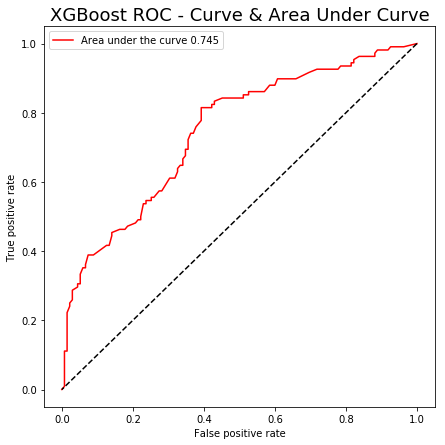

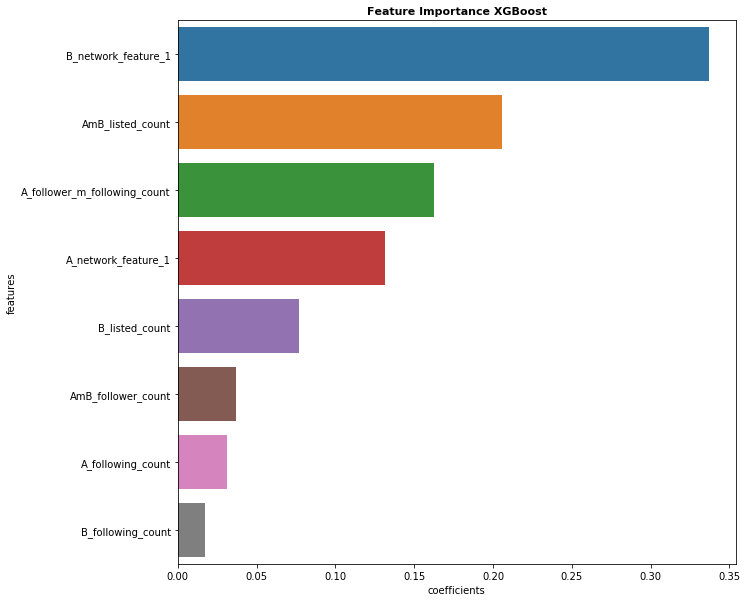

In [74]:
models = [
    XGBClassifier(random_state=1,n_estimators=50,learning_rate=0.02)
]

MLmodels = [
    MLmodel(models[0],'XGBoost','importance')
]

cols = ['AmB_listed_count','AmB_follower_count','B_network_feature_1',
        'A_follower_m_following_count','A_network_feature_1',
        'B_listed_count','A_following_count', 'B_following_count',
       ]

x_train, x_test, y_train, y_test = train_test_split(df_x[cols], df_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,False)

plt.figure(figsize=(10,10))
feature_importance(df_x[cols],MLmodels[0].model,model_name=MLmodels[0].name,model_type=MLmodels[0].model_type)    

# Dimensionality reduction

Try dimensionality reduction to reduce the over-fitting.

## Standartisation

In [41]:
def QuantileTransform(x_df,except_col = ['']):
    qt = preprocessing.QuantileTransformer(output_distribution='normal', random_state=1)
    cols = [x for x in x_df.columns if x not in except_col]
    model = qt.fit(x_df[cols])
    x_df[cols] = qt.transform(x_df[cols])
    return model

def StandardScaling(x_df,except_col = ['']):
    stsc = preprocessing.StandardScaler()
    cols = [x for x in x_df.columns if x not in except_col]
    model = stsc.fit(x_df[cols])
    x_df[cols] = stsc.transform(x_df[cols])

In [42]:
reduced_x = df_x.copy()
qtm = QuantileTransform(reduced_x)
ssc = StandardScaling(reduced_x)

## PCA

In [43]:
from sklearn.decomposition import PCA
# apply PCA
pca = PCA(n_components=0.95)
reduced_x_pca = pca.fit_transform(reduced_x)
explained_variance=pca.explained_variance_ratio_
explained_variance

array([ 0.21230006,  0.15505825,  0.11161197,  0.06251145,  0.0574997 ,
        0.05072662,  0.04846216,  0.03743599,  0.03489662,  0.02716541,
        0.02378778,  0.01874502,  0.01621607,  0.01334984,  0.0130381 ,
        0.01173561,  0.01041306,  0.01005757,  0.00978516,  0.00907727,
        0.00791082,  0.00784224,  0.00661901])

In [44]:
# Convert to DF
columns = ['pca_%i' % i for i in range(len(explained_variance))]
reduced_x_pca = pd.DataFrame(pca.transform(reduced_x), columns=columns, index=reduced_x.index)

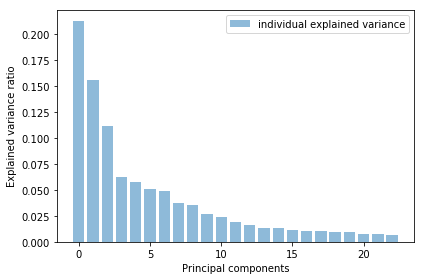

In [45]:
plt.figure(figsize=(6, 4))
# Individual explained variance
plt.bar(range(len(explained_variance)), explained_variance, alpha=0.5, align='center',
            label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=1,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
**********************TRAIN Sample***********************
Accuracy: 89.804% 
ROC AUC: 96.885% 

***********************TEST Sample***********************
Accuracy: 65.021% 
ROC AUC: 73.532% 



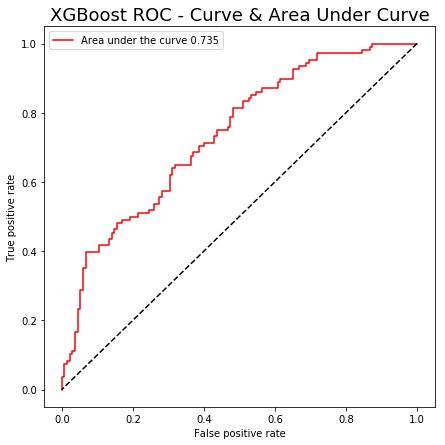

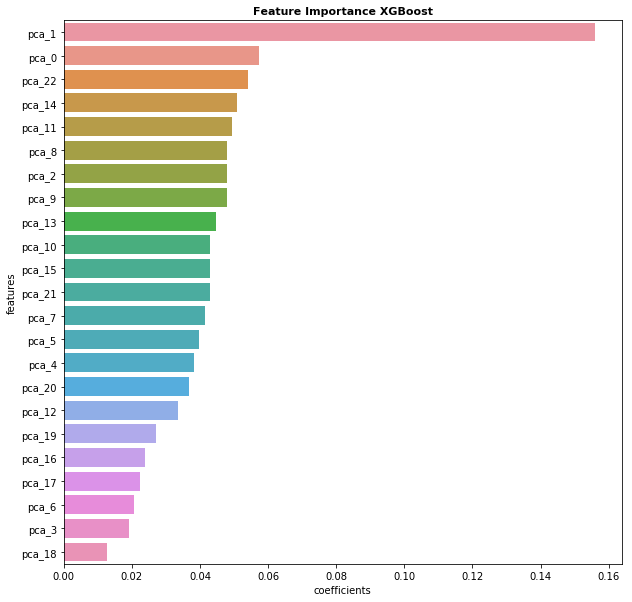

In [46]:
x_train, x_test, y_train, y_test = train_test_split(reduced_x_pca, df_y, test_size=0.2, random_state=1)
for model in MLmodels:
    model_res[model.name] = advanced_evaluate_model(model.model,model.name,x_train,y_train,x_test,y_test,False)

plt.figure(figsize=(10,10))
feature_importance(reduced_x_pca,MLmodels[0].model,model_name=MLmodels[0].name,model_type=MLmodels[0].model_type)    